In [ ]:
# Problem Set 1 - Neural network implementation

Team number: PS 1 B

Team members: 
- Giorgio Coppola (224545)
- Minho Kang (239742)
- Sofiya Berdiyeva (246934)

As described in section "2 Neural network implementation" of assignment 1, the goal is to build a shallow neural network from scratch using different approaches. To validate that your code is working and that the network is actually learning something, please use the following MNIST classification task. Finally, please submit proof of the learning progress as described in the assignment.

## Imports

In [5]:
import random
import pandas as pd
import numpy as np
from sklearn import model_selection
import sklearn.datasets as sk_datasets
import torchvision.datasets as torch_datasets
from torchvision import transforms
import torch
import matplotlib.pyplot as plt

from scratch.network import Network
from scratch.res_network import ResNetwork
from pytorch.network import TorchNetwork
from scratch.utils import *

import optuna
from sklearn.metrics import accuracy_score


In [6]:
# Automatically load changes in imported modules
%load_ext autoreload
%autoreload 2

# Explicitly set seed for reproducibility
GLOBAL_RANDOM_STATE = 42

random.seed(GLOBAL_RANDOM_STATE)
np.random.seed(GLOBAL_RANDOM_STATE)

## A) Neural Network Classifier from Scratch

### Data

In [7]:
# Download MNIST dataset
x, y_cat = sk_datasets.fetch_openml('mnist_784', version=1, return_X_y=True, cache=True, as_frame=False)

# Preprocess dataset
x = (x / 255).astype('float32')
y_cat = y_cat.astype(int)
# One-hot encode y
y = np.zeros((len(y_cat), 10))
for i, val in enumerate(y_cat):
    y[i, val] = 1

# Use only small subset of data for faster training
x = x[:1000]
y = y[:1000]

# Split data into train and validation set
x_train, x_val, y_train, y_val = model_selection.train_test_split(x, y, test_size=0.2, random_state=GLOBAL_RANDOM_STATE)


### ML Model & Training

In [8]:
fnn = Network(sizes=[784, 128, 64, 10], learning_rate=0.1, epochs=50)
fnn.fit(x_train, y_train, x_val, y_val, cosine_annealing_lr=False)

Epoch: 1, Training Time: 0.20s, Training Accuracy: 44.38%, Validation Accuracy: 41.00%
Epoch: 2, Training Time: 0.42s, Training Accuracy: 74.00%, Validation Accuracy: 70.00%
Epoch: 3, Training Time: 0.61s, Training Accuracy: 82.50%, Validation Accuracy: 80.00%
Epoch: 4, Training Time: 0.76s, Training Accuracy: 88.62%, Validation Accuracy: 82.00%
Epoch: 5, Training Time: 0.91s, Training Accuracy: 92.00%, Validation Accuracy: 83.50%
Epoch: 6, Training Time: 1.06s, Training Accuracy: 93.88%, Validation Accuracy: 84.50%
Epoch: 7, Training Time: 1.21s, Training Accuracy: 95.12%, Validation Accuracy: 83.00%
Epoch: 8, Training Time: 1.36s, Training Accuracy: 95.62%, Validation Accuracy: 83.00%
Epoch: 9, Training Time: 1.51s, Training Accuracy: 96.75%, Validation Accuracy: 84.50%
Epoch: 10, Training Time: 1.66s, Training Accuracy: 97.25%, Validation Accuracy: 85.00%
Epoch: 11, Training Time: 1.80s, Training Accuracy: 97.88%, Validation Accuracy: 84.50%
Epoch: 12, Training Time: 1.95s, Training

### Test cosine annealing scheduler

In [9]:
fnn.fit(x_train, y_train, x_val, y_val, cosine_annealing_lr=True)

Epoch: 1, Training Time: 0.19s, Training Accuracy: 99.50%, Validation Accuracy: 90.00%
Epoch: 2, Training Time: 0.40s, Training Accuracy: 99.50%, Validation Accuracy: 89.50%
Epoch: 3, Training Time: 0.62s, Training Accuracy: 99.62%, Validation Accuracy: 89.50%
Epoch: 4, Training Time: 0.84s, Training Accuracy: 99.62%, Validation Accuracy: 89.50%
Epoch: 5, Training Time: 1.06s, Training Accuracy: 99.62%, Validation Accuracy: 89.50%
Epoch: 6, Training Time: 1.28s, Training Accuracy: 99.62%, Validation Accuracy: 89.50%
Epoch: 7, Training Time: 1.48s, Training Accuracy: 99.62%, Validation Accuracy: 89.50%
Epoch: 8, Training Time: 1.67s, Training Accuracy: 99.62%, Validation Accuracy: 89.50%
Epoch: 9, Training Time: 1.87s, Training Accuracy: 99.62%, Validation Accuracy: 89.50%
Epoch: 10, Training Time: 2.12s, Training Accuracy: 99.62%, Validation Accuracy: 89.50%
Epoch: 11, Training Time: 2.30s, Training Accuracy: 99.62%, Validation Accuracy: 89.50%
Epoch: 12, Training Time: 2.51s, Training

### Test residual neural network

In [23]:
res_nn = ResNetwork(sizes=[784, 128, 64, 10], learning_rate=0.0005, epochs=100)
res_nn.fit(x_train, y_train, x_val, y_val)

Epoch: 1, Training Time: 0.17s, Training Accuracy: 13.63%, Validation Accuracy: 21.00%
Epoch: 2, Training Time: 0.36s, Training Accuracy: 13.38%, Validation Accuracy: 22.00%
Epoch: 3, Training Time: 0.56s, Training Accuracy: 13.38%, Validation Accuracy: 21.50%
Epoch: 4, Training Time: 0.74s, Training Accuracy: 14.12%, Validation Accuracy: 21.50%
Epoch: 5, Training Time: 0.91s, Training Accuracy: 18.50%, Validation Accuracy: 25.00%
Epoch: 6, Training Time: 1.09s, Training Accuracy: 19.00%, Validation Accuracy: 26.50%
Epoch: 7, Training Time: 1.28s, Training Accuracy: 19.62%, Validation Accuracy: 24.50%
Epoch: 8, Training Time: 1.47s, Training Accuracy: 22.75%, Validation Accuracy: 27.50%
Epoch: 9, Training Time: 1.66s, Training Accuracy: 22.50%, Validation Accuracy: 27.00%
Epoch: 10, Training Time: 1.84s, Training Accuracy: 23.62%, Validation Accuracy: 27.00%
Epoch: 11, Training Time: 2.04s, Training Accuracy: 24.75%, Validation Accuracy: 29.00%
Epoch: 12, Training Time: 2.23s, Training

## B) Neural Network Classifier using Torch

### Data

In [7]:
# Define data preprocessing steps
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])

# Download MNIST dataset
train_set = torch_datasets.MNIST('data', train=True, download=True, transform=transform)
val_set = torch_datasets.MNIST('data', train=False, download=True, transform=transform)

# Use only small subset of data for faster training
train_set = torch.utils.data.Subset(train_set, range(1000))
val_set = torch.utils.data.Subset(val_set, range(1000))

# Utilize PyTorch DataLoader from simplified & harmonized loading of data
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1)


### ML Model & Training

In [8]:
torch_nn = TorchNetwork(sizes=[784, 128, 64, 10], learning_rate=0.2, epochs=50, random_state=GLOBAL_RANDOM_STATE)
torch_nn.fit(train_loader, val_loader)

Epoch: 1, Training Time: 0.59s, Learning Rate: 0.2, Training Accuracy: 11.70%, Validation Accuracy: 9.90%
Epoch: 2, Training Time: 1.34s, Learning Rate: 0.2, Training Accuracy: 11.70%, Validation Accuracy: 9.90%
Epoch: 3, Training Time: 2.08s, Learning Rate: 0.2, Training Accuracy: 11.70%, Validation Accuracy: 9.90%
Epoch: 4, Training Time: 2.81s, Learning Rate: 0.2, Training Accuracy: 11.70%, Validation Accuracy: 9.90%
Epoch: 5, Training Time: 3.53s, Learning Rate: 0.2, Training Accuracy: 30.70%, Validation Accuracy: 26.80%
Epoch: 6, Training Time: 4.26s, Learning Rate: 0.2, Training Accuracy: 29.00%, Validation Accuracy: 26.80%
Epoch: 7, Training Time: 5.01s, Learning Rate: 0.2, Training Accuracy: 30.10%, Validation Accuracy: 28.10%
Epoch: 8, Training Time: 5.75s, Learning Rate: 0.2, Training Accuracy: 35.80%, Validation Accuracy: 31.30%
Epoch: 9, Training Time: 6.48s, Learning Rate: 0.2, Training Accuracy: 46.20%, Validation Accuracy: 42.60%
Epoch: 10, Training Time: 7.21s, Learning

## C) Visualize accuracy & hyperparameter tuning

Here, you should compare the accuracy of all trained models. Optionally, you can also show the results of hyperparameter tuning and comment which hyperparameters work best for this task.

In [9]:
def accuracy_plot(model):
    plt.plot(model.train_accuracies, label='Training Accuracy') #Need to implement in each model
    plt.plot(model.val_accuracies, label='Validation Accuracy') #Need to implement in each model
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.legend()
    plt.show()

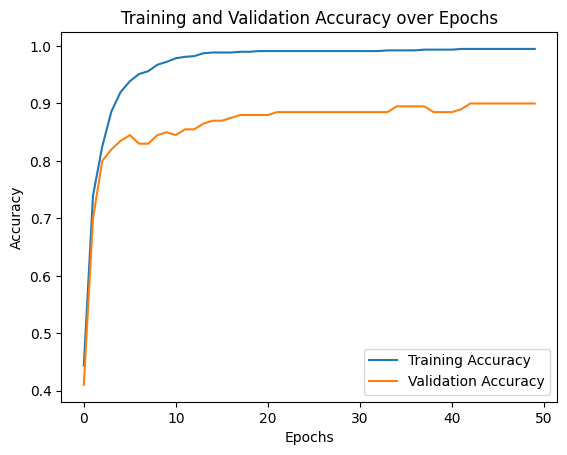

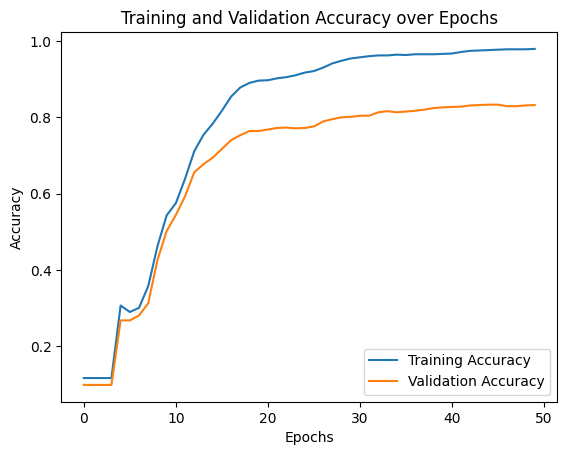

In [10]:
accuracy_plot(fnn)
#accuracy_plot(res_nn)
accuracy_plot(torch_nn)


## Hyperparameter tuning with optuna

In [10]:
# Optimization function for Optuna
def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_uniform('learning_rate', 1e-5, 1e-2)  # Uniform distribution for learning rate
    epochs = trial.suggest_int('epochs', 50, 150)  # Integer uniform distribution for epochs
    hidden_layer_1 = trial.suggest_int('hidden_layer_1', 64, 256)  # Hidden layer 1 size
    hidden_layer_2 = trial.suggest_int('hidden_layer_2', 32, 128)  # Hidden layer 2 size

    # Define the network with these hyperparameters
    res_nn = ResNetwork(
        sizes=[784, hidden_layer_1, hidden_layer_2, 10],
        learning_rate=learning_rate,
        epochs=epochs
    )

    # Train the network using the training data and validation data
    res_nn.fit(x_train, y_train, x_val, y_val)

    # Evaluate the model on the validation set
    val_accuracy = res_nn.compute_accuracy(x_val, y_val)

    return val_accuracy  # Return the validation accuracy to optimize

# Create an Optuna study to maximize the validation accuracy
study = optuna.create_study(direction='maximize')  # Direction can be 'maximize' for accuracy or 'minimize' for loss

# Optimize the objective function
study.optimize(objective, n_trials=100)  # Perform 100 trials

# Output the best hyperparameters found by Optuna
print('Best trial:', study.best_trial.params)


[I 2025-10-01 22:22:20,154] A new study created in memory with name: no-name-5ce7fe12-90aa-4fab-9931-eebf200c0288
/var/folders/wj/gmbmmmfd6zj_b509grz79xrh0000gn/T/ipykernel_76140/4282631329.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 1e-5, 1e-2)  # Uniform distribution for learning rate


Epoch: 1, Training Time: 0.23s, Training Accuracy: 9.38%, Validation Accuracy: 6.50%
Epoch: 2, Training Time: 0.49s, Training Accuracy: 9.38%, Validation Accuracy: 6.50%
Epoch: 3, Training Time: 0.75s, Training Accuracy: 9.38%, Validation Accuracy: 6.50%
Epoch: 4, Training Time: 0.99s, Training Accuracy: 9.38%, Validation Accuracy: 6.50%
Epoch: 5, Training Time: 1.24s, Training Accuracy: 9.38%, Validation Accuracy: 6.50%
Epoch: 6, Training Time: 1.47s, Training Accuracy: 9.38%, Validation Accuracy: 6.50%
Epoch: 7, Training Time: 1.70s, Training Accuracy: 9.38%, Validation Accuracy: 6.50%
Epoch: 8, Training Time: 1.92s, Training Accuracy: 9.38%, Validation Accuracy: 6.50%
Epoch: 9, Training Time: 2.15s, Training Accuracy: 9.38%, Validation Accuracy: 6.50%
Epoch: 10, Training Time: 2.37s, Training Accuracy: 9.38%, Validation Accuracy: 6.50%
Epoch: 11, Training Time: 2.59s, Training Accuracy: 9.38%, Validation Accuracy: 6.50%
Epoch: 12, Training Time: 2.81s, Training Accuracy: 9.38%, Vali

[I 2025-10-01 22:22:51,957] Trial 0 finished with value: 0.065 and parameters: {'learning_rate': 0.00631585202032942, 'epochs': 137, 'hidden_layer_1': 179, 'hidden_layer_2': 121}. Best is trial 0 with value: 0.065.


Epoch: 137, Training Time: 31.77s, Training Accuracy: 9.38%, Validation Accuracy: 6.50%
Epoch: 1, Training Time: 0.15s, Training Accuracy: 8.75%, Validation Accuracy: 12.50%
Epoch: 2, Training Time: 0.32s, Training Accuracy: 8.62%, Validation Accuracy: 11.00%
Epoch: 3, Training Time: 0.51s, Training Accuracy: 8.50%, Validation Accuracy: 11.00%
Epoch: 4, Training Time: 0.68s, Training Accuracy: 8.75%, Validation Accuracy: 11.50%
Epoch: 5, Training Time: 0.85s, Training Accuracy: 8.75%, Validation Accuracy: 11.50%
Epoch: 6, Training Time: 1.01s, Training Accuracy: 8.75%, Validation Accuracy: 11.50%
Epoch: 7, Training Time: 1.20s, Training Accuracy: 8.75%, Validation Accuracy: 11.50%
Epoch: 8, Training Time: 1.38s, Training Accuracy: 8.75%, Validation Accuracy: 11.50%
Epoch: 9, Training Time: 1.55s, Training Accuracy: 8.75%, Validation Accuracy: 11.50%
Epoch: 10, Training Time: 1.73s, Training Accuracy: 8.75%, Validation Accuracy: 11.50%
Epoch: 11, Training Time: 1.90s, Training Accuracy:

[I 2025-10-01 22:23:00,459] Trial 1 finished with value: 0.115 and parameters: {'learning_rate': 0.0035086255987374247, 'epochs': 50, 'hidden_layer_1': 105, 'hidden_layer_2': 74}. Best is trial 1 with value: 0.115.


Epoch: 50, Training Time: 8.47s, Training Accuracy: 8.75%, Validation Accuracy: 11.50%
Epoch: 1, Training Time: 0.19s, Training Accuracy: 13.38%, Validation Accuracy: 12.50%
Epoch: 2, Training Time: 0.42s, Training Accuracy: 13.50%, Validation Accuracy: 12.00%
Epoch: 3, Training Time: 0.64s, Training Accuracy: 13.50%, Validation Accuracy: 12.00%
Epoch: 4, Training Time: 0.86s, Training Accuracy: 22.50%, Validation Accuracy: 21.50%
Epoch: 5, Training Time: 1.08s, Training Accuracy: 18.25%, Validation Accuracy: 16.00%
Epoch: 6, Training Time: 1.29s, Training Accuracy: 18.62%, Validation Accuracy: 19.00%
Epoch: 7, Training Time: 1.51s, Training Accuracy: 15.00%, Validation Accuracy: 13.00%
Epoch: 8, Training Time: 1.72s, Training Accuracy: 16.62%, Validation Accuracy: 14.00%
Epoch: 9, Training Time: 1.95s, Training Accuracy: 19.75%, Validation Accuracy: 17.00%
Epoch: 10, Training Time: 2.17s, Training Accuracy: 11.88%, Validation Accuracy: 10.00%
Epoch: 11, Training Time: 2.38s, Training 

[I 2025-10-01 22:23:14,902] Trial 2 finished with value: 0.115 and parameters: {'learning_rate': 0.006719214862988771, 'epochs': 63, 'hidden_layer_1': 181, 'hidden_layer_2': 94}. Best is trial 1 with value: 0.115.


Epoch: 63, Training Time: 14.41s, Training Accuracy: 12.25%, Validation Accuracy: 11.50%
Epoch: 1, Training Time: 0.11s, Training Accuracy: 10.00%, Validation Accuracy: 14.00%
Epoch: 2, Training Time: 0.26s, Training Accuracy: 17.50%, Validation Accuracy: 12.50%
Epoch: 3, Training Time: 0.42s, Training Accuracy: 19.12%, Validation Accuracy: 15.50%
Epoch: 4, Training Time: 0.56s, Training Accuracy: 14.25%, Validation Accuracy: 12.00%
Epoch: 5, Training Time: 0.70s, Training Accuracy: 15.62%, Validation Accuracy: 15.00%
Epoch: 6, Training Time: 0.84s, Training Accuracy: 20.75%, Validation Accuracy: 17.50%
Epoch: 7, Training Time: 0.98s, Training Accuracy: 18.12%, Validation Accuracy: 16.00%
Epoch: 8, Training Time: 1.13s, Training Accuracy: 20.12%, Validation Accuracy: 18.50%
Epoch: 9, Training Time: 1.27s, Training Accuracy: 21.00%, Validation Accuracy: 19.00%
Epoch: 10, Training Time: 1.41s, Training Accuracy: 21.00%, Validation Accuracy: 18.00%
Epoch: 11, Training Time: 1.55s, Trainin

[I 2025-10-01 22:23:28,352] Trial 3 finished with value: 0.195 and parameters: {'learning_rate': 0.009343861613505505, 'epochs': 96, 'hidden_layer_1': 79, 'hidden_layer_2': 70}. Best is trial 3 with value: 0.195.


Epoch: 96, Training Time: 13.42s, Training Accuracy: 21.25%, Validation Accuracy: 19.50%
Epoch: 1, Training Time: 0.18s, Training Accuracy: 10.25%, Validation Accuracy: 10.00%
Epoch: 2, Training Time: 0.38s, Training Accuracy: 9.75%, Validation Accuracy: 9.50%
Epoch: 3, Training Time: 0.57s, Training Accuracy: 9.88%, Validation Accuracy: 10.50%
Epoch: 4, Training Time: 0.78s, Training Accuracy: 9.88%, Validation Accuracy: 10.50%
Epoch: 5, Training Time: 0.98s, Training Accuracy: 9.88%, Validation Accuracy: 10.50%
Epoch: 6, Training Time: 1.18s, Training Accuracy: 9.88%, Validation Accuracy: 10.50%
Epoch: 7, Training Time: 1.37s, Training Accuracy: 9.88%, Validation Accuracy: 10.50%
Epoch: 8, Training Time: 1.58s, Training Accuracy: 9.88%, Validation Accuracy: 10.50%
Epoch: 9, Training Time: 1.79s, Training Accuracy: 9.88%, Validation Accuracy: 10.50%
Epoch: 10, Training Time: 1.98s, Training Accuracy: 9.88%, Validation Accuracy: 10.50%
Epoch: 11, Training Time: 2.19s, Training Accuracy

[I 2025-10-01 22:23:56,262] Trial 4 finished with value: 0.105 and parameters: {'learning_rate': 0.006790879822977527, 'epochs': 143, 'hidden_layer_1': 139, 'hidden_layer_2': 54}. Best is trial 3 with value: 0.195.


Epoch: 1, Training Time: 0.26s, Training Accuracy: 7.12%, Validation Accuracy: 6.00%
Epoch: 2, Training Time: 0.54s, Training Accuracy: 9.25%, Validation Accuracy: 8.00%
Epoch: 3, Training Time: 0.81s, Training Accuracy: 6.88%, Validation Accuracy: 5.00%
Epoch: 4, Training Time: 1.09s, Training Accuracy: 6.25%, Validation Accuracy: 7.00%
Epoch: 5, Training Time: 1.37s, Training Accuracy: 6.25%, Validation Accuracy: 5.50%
Epoch: 6, Training Time: 1.65s, Training Accuracy: 5.38%, Validation Accuracy: 3.50%
Epoch: 7, Training Time: 1.92s, Training Accuracy: 7.62%, Validation Accuracy: 8.00%
Epoch: 8, Training Time: 2.21s, Training Accuracy: 8.12%, Validation Accuracy: 7.50%
Epoch: 9, Training Time: 2.49s, Training Accuracy: 9.38%, Validation Accuracy: 9.50%
Epoch: 10, Training Time: 2.77s, Training Accuracy: 9.50%, Validation Accuracy: 8.50%
Epoch: 11, Training Time: 3.05s, Training Accuracy: 9.50%, Validation Accuracy: 8.50%
Epoch: 12, Training Time: 3.32s, Training Accuracy: 9.62%, Vali

[I 2025-10-01 22:24:23,082] Trial 5 finished with value: 0.085 and parameters: {'learning_rate': 0.008445027127651005, 'epochs': 93, 'hidden_layer_1': 240, 'hidden_layer_2': 120}. Best is trial 3 with value: 0.195.


Epoch: 93, Training Time: 26.78s, Training Accuracy: 9.50%, Validation Accuracy: 8.50%
Epoch: 1, Training Time: 0.13s, Training Accuracy: 12.38%, Validation Accuracy: 10.50%
Epoch: 2, Training Time: 0.29s, Training Accuracy: 12.12%, Validation Accuracy: 10.50%
Epoch: 3, Training Time: 0.45s, Training Accuracy: 12.12%, Validation Accuracy: 10.00%
Epoch: 4, Training Time: 0.62s, Training Accuracy: 12.12%, Validation Accuracy: 10.00%
Epoch: 5, Training Time: 0.78s, Training Accuracy: 12.12%, Validation Accuracy: 10.00%
Epoch: 6, Training Time: 0.96s, Training Accuracy: 12.12%, Validation Accuracy: 10.00%
Epoch: 7, Training Time: 1.14s, Training Accuracy: 12.88%, Validation Accuracy: 12.00%
Epoch: 8, Training Time: 1.30s, Training Accuracy: 12.88%, Validation Accuracy: 12.00%
Epoch: 9, Training Time: 1.47s, Training Accuracy: 14.37%, Validation Accuracy: 13.50%
Epoch: 10, Training Time: 1.65s, Training Accuracy: 17.50%, Validation Accuracy: 17.50%
Epoch: 11, Training Time: 1.83s, Training 

[I 2025-10-01 22:24:36,015] Trial 6 finished with value: 0.195 and parameters: {'learning_rate': 0.00999820446413327, 'epochs': 79, 'hidden_layer_1': 97, 'hidden_layer_2': 103}. Best is trial 3 with value: 0.195.


Epoch: 78, Training Time: 12.74s, Training Accuracy: 18.50%, Validation Accuracy: 18.00%
Epoch: 79, Training Time: 12.90s, Training Accuracy: 22.12%, Validation Accuracy: 19.50%
Epoch: 1, Training Time: 0.17s, Training Accuracy: 14.88%, Validation Accuracy: 14.00%
Epoch: 2, Training Time: 0.34s, Training Accuracy: 13.12%, Validation Accuracy: 18.50%
Epoch: 3, Training Time: 0.52s, Training Accuracy: 13.12%, Validation Accuracy: 19.00%
Epoch: 4, Training Time: 0.71s, Training Accuracy: 13.12%, Validation Accuracy: 19.00%
Epoch: 5, Training Time: 0.92s, Training Accuracy: 13.75%, Validation Accuracy: 19.00%
Epoch: 6, Training Time: 1.10s, Training Accuracy: 15.62%, Validation Accuracy: 18.50%
Epoch: 7, Training Time: 1.31s, Training Accuracy: 16.12%, Validation Accuracy: 20.00%
Epoch: 8, Training Time: 1.49s, Training Accuracy: 15.38%, Validation Accuracy: 16.50%
Epoch: 9, Training Time: 1.70s, Training Accuracy: 15.50%, Validation Accuracy: 17.50%
Epoch: 10, Training Time: 1.89s, Traini

[I 2025-10-01 22:24:55,586] Trial 7 finished with value: 0.255 and parameters: {'learning_rate': 0.00495947274790002, 'epochs': 102, 'hidden_layer_1': 132, 'hidden_layer_2': 80}. Best is trial 7 with value: 0.255.


Epoch: 101, Training Time: 19.37s, Training Accuracy: 21.00%, Validation Accuracy: 25.50%
Epoch: 102, Training Time: 19.54s, Training Accuracy: 21.12%, Validation Accuracy: 25.50%
Epoch: 1, Training Time: 0.11s, Training Accuracy: 12.38%, Validation Accuracy: 9.50%
Epoch: 2, Training Time: 0.24s, Training Accuracy: 9.75%, Validation Accuracy: 8.00%
Epoch: 3, Training Time: 0.37s, Training Accuracy: 9.88%, Validation Accuracy: 8.00%
Epoch: 4, Training Time: 0.50s, Training Accuracy: 9.88%, Validation Accuracy: 8.00%
Epoch: 5, Training Time: 0.63s, Training Accuracy: 9.88%, Validation Accuracy: 8.00%
Epoch: 6, Training Time: 0.76s, Training Accuracy: 9.88%, Validation Accuracy: 8.00%
Epoch: 7, Training Time: 0.89s, Training Accuracy: 9.88%, Validation Accuracy: 8.00%
Epoch: 8, Training Time: 1.02s, Training Accuracy: 9.88%, Validation Accuracy: 8.00%
Epoch: 9, Training Time: 1.16s, Training Accuracy: 9.88%, Validation Accuracy: 8.00%
Epoch: 10, Training Time: 1.29s, Training Accuracy: 9.

[I 2025-10-01 22:25:10,636] Trial 8 finished with value: 0.08 and parameters: {'learning_rate': 0.00676290476997557, 'epochs': 114, 'hidden_layer_1': 75, 'hidden_layer_2': 56}. Best is trial 7 with value: 0.255.


Epoch: 113, Training Time: 14.90s, Training Accuracy: 9.88%, Validation Accuracy: 8.00%
Epoch: 114, Training Time: 15.02s, Training Accuracy: 9.88%, Validation Accuracy: 8.00%
Epoch: 1, Training Time: 0.13s, Training Accuracy: 11.62%, Validation Accuracy: 10.00%
Epoch: 2, Training Time: 0.28s, Training Accuracy: 11.00%, Validation Accuracy: 10.50%
Epoch: 3, Training Time: 0.42s, Training Accuracy: 13.00%, Validation Accuracy: 12.00%
Epoch: 4, Training Time: 0.57s, Training Accuracy: 14.00%, Validation Accuracy: 8.50%
Epoch: 5, Training Time: 0.71s, Training Accuracy: 12.88%, Validation Accuracy: 8.50%
Epoch: 6, Training Time: 0.86s, Training Accuracy: 13.38%, Validation Accuracy: 8.50%
Epoch: 7, Training Time: 1.01s, Training Accuracy: 12.88%, Validation Accuracy: 9.00%
Epoch: 8, Training Time: 1.16s, Training Accuracy: 16.25%, Validation Accuracy: 12.50%
Epoch: 9, Training Time: 1.30s, Training Accuracy: 16.38%, Validation Accuracy: 12.50%
Epoch: 10, Training Time: 1.45s, Training Acc

[I 2025-10-01 22:25:18,424] Trial 9 finished with value: 0.1 and parameters: {'learning_rate': 0.0061452788348019234, 'epochs': 51, 'hidden_layer_1': 89, 'hidden_layer_2': 88}. Best is trial 7 with value: 0.255.


Epoch: 51, Training Time: 7.76s, Training Accuracy: 13.25%, Validation Accuracy: 10.00%
Epoch: 1, Training Time: 0.23s, Training Accuracy: 11.75%, Validation Accuracy: 12.00%
Epoch: 2, Training Time: 0.50s, Training Accuracy: 11.50%, Validation Accuracy: 12.00%
Epoch: 3, Training Time: 0.77s, Training Accuracy: 10.88%, Validation Accuracy: 12.00%
Epoch: 4, Training Time: 1.04s, Training Accuracy: 12.50%, Validation Accuracy: 13.00%
Epoch: 5, Training Time: 1.30s, Training Accuracy: 13.00%, Validation Accuracy: 13.00%
Epoch: 6, Training Time: 1.54s, Training Accuracy: 12.75%, Validation Accuracy: 13.50%
Epoch: 7, Training Time: 1.80s, Training Accuracy: 13.12%, Validation Accuracy: 13.00%
Epoch: 8, Training Time: 2.05s, Training Accuracy: 13.38%, Validation Accuracy: 13.00%
Epoch: 9, Training Time: 2.30s, Training Accuracy: 13.75%, Validation Accuracy: 15.50%
Epoch: 10, Training Time: 2.56s, Training Accuracy: 14.25%, Validation Accuracy: 14.50%
Epoch: 11, Training Time: 2.81s, Training

[I 2025-10-01 22:25:49,038] Trial 10 finished with value: 0.205 and parameters: {'learning_rate': 7.471568756212653e-05, 'epochs': 117, 'hidden_layer_1': 225, 'hidden_layer_2': 38}. Best is trial 7 with value: 0.255.


Epoch: 117, Training Time: 30.57s, Training Accuracy: 23.50%, Validation Accuracy: 20.50%
Epoch: 1, Training Time: 0.33s, Training Accuracy: 9.50%, Validation Accuracy: 8.50%
Epoch: 2, Training Time: 0.68s, Training Accuracy: 9.38%, Validation Accuracy: 8.00%
Epoch: 3, Training Time: 1.03s, Training Accuracy: 9.75%, Validation Accuracy: 8.00%
Epoch: 4, Training Time: 1.41s, Training Accuracy: 10.38%, Validation Accuracy: 9.00%
Epoch: 5, Training Time: 1.78s, Training Accuracy: 10.50%, Validation Accuracy: 9.00%
Epoch: 6, Training Time: 2.16s, Training Accuracy: 10.50%, Validation Accuracy: 10.00%
Epoch: 7, Training Time: 2.54s, Training Accuracy: 10.62%, Validation Accuracy: 10.00%
Epoch: 8, Training Time: 2.91s, Training Accuracy: 10.50%, Validation Accuracy: 9.00%
Epoch: 9, Training Time: 3.29s, Training Accuracy: 10.38%, Validation Accuracy: 10.00%
Epoch: 10, Training Time: 3.69s, Training Accuracy: 10.38%, Validation Accuracy: 10.00%
Epoch: 11, Training Time: 4.05s, Training Accura

[I 2025-10-01 22:26:28,959] Trial 11 finished with value: 0.18 and parameters: {'learning_rate': 4.5695298976070574e-05, 'epochs': 109, 'hidden_layer_1': 252, 'hidden_layer_2': 32}. Best is trial 7 with value: 0.255.


Epoch: 109, Training Time: 39.88s, Training Accuracy: 18.50%, Validation Accuracy: 18.00%
Epoch: 1, Training Time: 0.24s, Training Accuracy: 8.50%, Validation Accuracy: 11.00%
Epoch: 2, Training Time: 0.50s, Training Accuracy: 8.62%, Validation Accuracy: 13.00%
Epoch: 3, Training Time: 0.77s, Training Accuracy: 8.38%, Validation Accuracy: 13.00%
Epoch: 4, Training Time: 1.04s, Training Accuracy: 8.62%, Validation Accuracy: 13.00%
Epoch: 5, Training Time: 1.30s, Training Accuracy: 9.00%, Validation Accuracy: 14.00%
Epoch: 6, Training Time: 1.56s, Training Accuracy: 9.00%, Validation Accuracy: 13.50%
Epoch: 7, Training Time: 1.83s, Training Accuracy: 8.75%, Validation Accuracy: 13.50%
Epoch: 8, Training Time: 2.10s, Training Accuracy: 9.62%, Validation Accuracy: 13.50%
Epoch: 9, Training Time: 2.36s, Training Accuracy: 11.75%, Validation Accuracy: 15.00%
Epoch: 10, Training Time: 2.63s, Training Accuracy: 12.88%, Validation Accuracy: 14.00%
Epoch: 11, Training Time: 2.89s, Training Accur

[I 2025-10-01 22:27:00,020] Trial 12 finished with value: 0.12 and parameters: {'learning_rate': 0.0021146839740282942, 'epochs': 121, 'hidden_layer_1': 215, 'hidden_layer_2': 37}. Best is trial 7 with value: 0.255.


Epoch: 121, Training Time: 31.02s, Training Accuracy: 12.00%, Validation Accuracy: 12.00%
Epoch: 1, Training Time: 0.16s, Training Accuracy: 8.88%, Validation Accuracy: 7.50%
Epoch: 2, Training Time: 0.35s, Training Accuracy: 9.38%, Validation Accuracy: 8.00%
Epoch: 3, Training Time: 0.54s, Training Accuracy: 9.62%, Validation Accuracy: 8.00%
Epoch: 4, Training Time: 0.72s, Training Accuracy: 9.75%, Validation Accuracy: 8.00%
Epoch: 5, Training Time: 0.90s, Training Accuracy: 9.75%, Validation Accuracy: 8.00%
Epoch: 6, Training Time: 1.08s, Training Accuracy: 9.75%, Validation Accuracy: 8.00%
Epoch: 7, Training Time: 1.26s, Training Accuracy: 9.75%, Validation Accuracy: 8.00%
Epoch: 8, Training Time: 1.45s, Training Accuracy: 9.88%, Validation Accuracy: 8.00%
Epoch: 9, Training Time: 1.64s, Training Accuracy: 10.00%, Validation Accuracy: 8.00%
Epoch: 10, Training Time: 1.82s, Training Accuracy: 10.12%, Validation Accuracy: 8.50%
Epoch: 11, Training Time: 2.00s, Training Accuracy: 10.00

[I 2025-10-01 22:27:25,260] Trial 13 finished with value: 0.11 and parameters: {'learning_rate': 7.30113390286087e-05, 'epochs': 130, 'hidden_layer_1': 141, 'hidden_layer_2': 47}. Best is trial 7 with value: 0.255.


Epoch: 130, Training Time: 25.20s, Training Accuracy: 15.00%, Validation Accuracy: 11.00%
Epoch: 1, Training Time: 0.21s, Training Accuracy: 15.75%, Validation Accuracy: 16.50%
Epoch: 2, Training Time: 0.44s, Training Accuracy: 21.62%, Validation Accuracy: 20.00%
Epoch: 3, Training Time: 0.69s, Training Accuracy: 19.00%, Validation Accuracy: 14.00%
Epoch: 4, Training Time: 0.94s, Training Accuracy: 17.62%, Validation Accuracy: 13.50%
Epoch: 5, Training Time: 1.18s, Training Accuracy: 17.50%, Validation Accuracy: 13.00%
Epoch: 6, Training Time: 1.42s, Training Accuracy: 17.50%, Validation Accuracy: 14.50%
Epoch: 7, Training Time: 1.65s, Training Accuracy: 17.62%, Validation Accuracy: 14.00%
Epoch: 8, Training Time: 1.91s, Training Accuracy: 16.50%, Validation Accuracy: 12.50%
Epoch: 9, Training Time: 2.15s, Training Accuracy: 16.50%, Validation Accuracy: 12.50%
Epoch: 10, Training Time: 2.40s, Training Accuracy: 16.00%, Validation Accuracy: 12.50%
Epoch: 11, Training Time: 2.63s, Traini

[I 2025-10-01 22:27:46,404] Trial 14 finished with value: 0.13 and parameters: {'learning_rate': 0.003455873672198747, 'epochs': 84, 'hidden_layer_1': 208, 'hidden_layer_2': 65}. Best is trial 7 with value: 0.255.


Epoch: 84, Training Time: 21.10s, Training Accuracy: 15.88%, Validation Accuracy: 13.00%
Epoch: 1, Training Time: 0.17s, Training Accuracy: 12.00%, Validation Accuracy: 7.50%
Epoch: 2, Training Time: 0.36s, Training Accuracy: 11.25%, Validation Accuracy: 7.50%
Epoch: 3, Training Time: 0.57s, Training Accuracy: 11.50%, Validation Accuracy: 7.00%
Epoch: 4, Training Time: 0.76s, Training Accuracy: 11.50%, Validation Accuracy: 7.00%
Epoch: 5, Training Time: 0.95s, Training Accuracy: 11.50%, Validation Accuracy: 7.00%
Epoch: 6, Training Time: 1.17s, Training Accuracy: 11.50%, Validation Accuracy: 7.00%
Epoch: 7, Training Time: 1.35s, Training Accuracy: 11.50%, Validation Accuracy: 7.00%
Epoch: 8, Training Time: 1.54s, Training Accuracy: 11.38%, Validation Accuracy: 7.00%
Epoch: 9, Training Time: 1.72s, Training Accuracy: 11.12%, Validation Accuracy: 7.00%
Epoch: 10, Training Time: 1.91s, Training Accuracy: 11.50%, Validation Accuracy: 7.50%
Epoch: 11, Training Time: 2.09s, Training Accuracy

[I 2025-10-01 22:28:06,645] Trial 15 finished with value: 0.265 and parameters: {'learning_rate': 0.0017478023097650729, 'epochs': 106, 'hidden_layer_1': 131, 'hidden_layer_2': 103}. Best is trial 15 with value: 0.265.


Epoch: 106, Training Time: 20.21s, Training Accuracy: 30.50%, Validation Accuracy: 26.50%
Epoch: 1, Training Time: 0.16s, Training Accuracy: 9.88%, Validation Accuracy: 11.50%
Epoch: 2, Training Time: 0.35s, Training Accuracy: 12.25%, Validation Accuracy: 12.50%
Epoch: 3, Training Time: 0.56s, Training Accuracy: 12.38%, Validation Accuracy: 12.50%
Epoch: 4, Training Time: 0.75s, Training Accuracy: 12.50%, Validation Accuracy: 12.50%
Epoch: 5, Training Time: 0.93s, Training Accuracy: 12.38%, Validation Accuracy: 12.50%
Epoch: 6, Training Time: 1.13s, Training Accuracy: 12.38%, Validation Accuracy: 12.50%
Epoch: 7, Training Time: 1.34s, Training Accuracy: 12.12%, Validation Accuracy: 12.50%
Epoch: 8, Training Time: 1.53s, Training Accuracy: 12.00%, Validation Accuracy: 12.50%
Epoch: 9, Training Time: 1.72s, Training Accuracy: 11.88%, Validation Accuracy: 12.50%
Epoch: 10, Training Time: 1.92s, Training Accuracy: 12.25%, Validation Accuracy: 12.00%
Epoch: 11, Training Time: 2.11s, Trainin

[I 2025-10-01 22:28:26,971] Trial 16 finished with value: 0.12 and parameters: {'learning_rate': 0.0019480909860999489, 'epochs': 106, 'hidden_layer_1': 122, 'hidden_layer_2': 105}. Best is trial 15 with value: 0.265.


Epoch: 106, Training Time: 20.29s, Training Accuracy: 12.25%, Validation Accuracy: 12.00%
Epoch: 1, Training Time: 0.20s, Training Accuracy: 10.00%, Validation Accuracy: 11.50%
Epoch: 2, Training Time: 0.43s, Training Accuracy: 13.12%, Validation Accuracy: 14.00%
Epoch: 3, Training Time: 0.64s, Training Accuracy: 12.38%, Validation Accuracy: 13.00%
Epoch: 4, Training Time: 0.88s, Training Accuracy: 12.38%, Validation Accuracy: 13.00%
Epoch: 5, Training Time: 1.11s, Training Accuracy: 12.38%, Validation Accuracy: 13.00%
Epoch: 6, Training Time: 1.34s, Training Accuracy: 12.62%, Validation Accuracy: 13.50%
Epoch: 7, Training Time: 1.57s, Training Accuracy: 12.50%, Validation Accuracy: 12.50%
Epoch: 8, Training Time: 1.79s, Training Accuracy: 12.50%, Validation Accuracy: 12.50%
Epoch: 9, Training Time: 2.03s, Training Accuracy: 13.12%, Validation Accuracy: 14.50%
Epoch: 10, Training Time: 2.25s, Training Accuracy: 13.38%, Validation Accuracy: 14.50%
Epoch: 11, Training Time: 2.47s, Traini

[I 2025-10-01 22:28:43,900] Trial 17 finished with value: 0.145 and parameters: {'learning_rate': 0.0043237146955734575, 'epochs': 77, 'hidden_layer_1': 164, 'hidden_layer_2': 84}. Best is trial 15 with value: 0.265.


Epoch: 77, Training Time: 16.89s, Training Accuracy: 13.38%, Validation Accuracy: 14.50%
Epoch: 1, Training Time: 0.15s, Training Accuracy: 14.88%, Validation Accuracy: 13.00%
Epoch: 2, Training Time: 0.33s, Training Accuracy: 15.38%, Validation Accuracy: 12.50%
Epoch: 3, Training Time: 0.52s, Training Accuracy: 15.12%, Validation Accuracy: 13.00%
Epoch: 4, Training Time: 0.71s, Training Accuracy: 17.62%, Validation Accuracy: 17.00%
Epoch: 5, Training Time: 0.89s, Training Accuracy: 17.00%, Validation Accuracy: 16.00%
Epoch: 6, Training Time: 1.07s, Training Accuracy: 17.88%, Validation Accuracy: 16.00%
Epoch: 7, Training Time: 1.25s, Training Accuracy: 18.62%, Validation Accuracy: 17.00%
Epoch: 8, Training Time: 1.43s, Training Accuracy: 15.25%, Validation Accuracy: 14.50%
Epoch: 9, Training Time: 1.61s, Training Accuracy: 15.25%, Validation Accuracy: 14.50%
Epoch: 10, Training Time: 1.79s, Training Accuracy: 14.37%, Validation Accuracy: 14.00%
Epoch: 11, Training Time: 1.97s, Trainin

[I 2025-10-01 22:29:08,003] Trial 18 finished with value: 0.22 and parameters: {'learning_rate': 0.0020130014026450258, 'epochs': 127, 'hidden_layer_1': 126, 'hidden_layer_2': 107}. Best is trial 15 with value: 0.265.


Epoch: 126, Training Time: 23.89s, Training Accuracy: 28.12%, Validation Accuracy: 21.50%
Epoch: 127, Training Time: 24.07s, Training Accuracy: 27.75%, Validation Accuracy: 22.00%
Epoch: 1, Training Time: 0.18s, Training Accuracy: 10.25%, Validation Accuracy: 9.00%
Epoch: 2, Training Time: 0.38s, Training Accuracy: 9.38%, Validation Accuracy: 6.00%
Epoch: 3, Training Time: 0.59s, Training Accuracy: 9.75%, Validation Accuracy: 7.00%
Epoch: 4, Training Time: 0.79s, Training Accuracy: 9.62%, Validation Accuracy: 7.00%
Epoch: 5, Training Time: 0.99s, Training Accuracy: 9.62%, Validation Accuracy: 7.00%
Epoch: 6, Training Time: 1.20s, Training Accuracy: 9.62%, Validation Accuracy: 6.50%
Epoch: 7, Training Time: 1.41s, Training Accuracy: 9.62%, Validation Accuracy: 7.00%
Epoch: 8, Training Time: 1.62s, Training Accuracy: 9.62%, Validation Accuracy: 7.00%
Epoch: 9, Training Time: 1.83s, Training Accuracy: 9.62%, Validation Accuracy: 7.00%
Epoch: 10, Training Time: 2.04s, Training Accuracy: 9.

[I 2025-10-01 22:29:29,515] Trial 19 finished with value: 0.065 and parameters: {'learning_rate': 0.005087996308865278, 'epochs': 99, 'hidden_layer_1': 158, 'hidden_layer_2': 96}. Best is trial 15 with value: 0.265.


Epoch: 1, Training Time: 0.15s, Training Accuracy: 9.12%, Validation Accuracy: 11.50%
Epoch: 2, Training Time: 0.34s, Training Accuracy: 9.00%, Validation Accuracy: 11.50%
Epoch: 3, Training Time: 0.53s, Training Accuracy: 8.50%, Validation Accuracy: 12.50%
Epoch: 4, Training Time: 0.70s, Training Accuracy: 8.62%, Validation Accuracy: 12.50%
Epoch: 5, Training Time: 0.87s, Training Accuracy: 8.50%, Validation Accuracy: 12.50%
Epoch: 6, Training Time: 1.04s, Training Accuracy: 8.50%, Validation Accuracy: 12.50%
Epoch: 7, Training Time: 1.20s, Training Accuracy: 8.50%, Validation Accuracy: 12.50%
Epoch: 8, Training Time: 1.37s, Training Accuracy: 8.50%, Validation Accuracy: 12.50%
Epoch: 9, Training Time: 1.53s, Training Accuracy: 8.50%, Validation Accuracy: 12.50%
Epoch: 10, Training Time: 1.70s, Training Accuracy: 8.50%, Validation Accuracy: 12.50%
Epoch: 11, Training Time: 1.87s, Training Accuracy: 8.50%, Validation Accuracy: 12.50%
Epoch: 12, Training Time: 2.03s, Training Accuracy: 

[I 2025-10-01 22:29:55,168] Trial 20 finished with value: 0.13 and parameters: {'learning_rate': 0.0011581251737868637, 'epochs': 150, 'hidden_layer_1': 107, 'hidden_layer_2': 113}. Best is trial 15 with value: 0.265.


Epoch: 150, Training Time: 25.62s, Training Accuracy: 8.62%, Validation Accuracy: 13.00%
Epoch: 1, Training Time: 0.16s, Training Accuracy: 16.75%, Validation Accuracy: 12.50%
Epoch: 2, Training Time: 0.35s, Training Accuracy: 23.25%, Validation Accuracy: 18.50%
Epoch: 3, Training Time: 0.52s, Training Accuracy: 23.25%, Validation Accuracy: 18.50%
Epoch: 4, Training Time: 0.70s, Training Accuracy: 21.12%, Validation Accuracy: 18.50%
Epoch: 5, Training Time: 0.88s, Training Accuracy: 22.00%, Validation Accuracy: 19.00%
Epoch: 6, Training Time: 1.06s, Training Accuracy: 23.88%, Validation Accuracy: 20.00%
Epoch: 7, Training Time: 1.24s, Training Accuracy: 25.37%, Validation Accuracy: 23.00%
Epoch: 8, Training Time: 1.42s, Training Accuracy: 26.62%, Validation Accuracy: 25.50%
Epoch: 9, Training Time: 1.60s, Training Accuracy: 27.62%, Validation Accuracy: 24.00%
Epoch: 10, Training Time: 1.78s, Training Accuracy: 26.88%, Validation Accuracy: 23.50%
Epoch: 11, Training Time: 1.97s, Trainin

[I 2025-10-01 22:30:19,125] Trial 21 finished with value: 0.285 and parameters: {'learning_rate': 0.002543234925804685, 'epochs': 127, 'hidden_layer_1': 126, 'hidden_layer_2': 108}. Best is trial 21 with value: 0.285.


Epoch: 126, Training Time: 23.75s, Training Accuracy: 33.25%, Validation Accuracy: 27.50%
Epoch: 127, Training Time: 23.92s, Training Accuracy: 33.00%, Validation Accuracy: 28.50%
Epoch: 1, Training Time: 0.15s, Training Accuracy: 13.12%, Validation Accuracy: 12.50%
Epoch: 2, Training Time: 0.34s, Training Accuracy: 9.00%, Validation Accuracy: 7.50%
Epoch: 3, Training Time: 0.53s, Training Accuracy: 9.25%, Validation Accuracy: 7.00%
Epoch: 4, Training Time: 0.71s, Training Accuracy: 10.12%, Validation Accuracy: 9.50%
Epoch: 5, Training Time: 0.89s, Training Accuracy: 9.25%, Validation Accuracy: 8.50%
Epoch: 6, Training Time: 1.08s, Training Accuracy: 9.25%, Validation Accuracy: 8.50%
Epoch: 7, Training Time: 1.27s, Training Accuracy: 9.25%, Validation Accuracy: 8.50%
Epoch: 8, Training Time: 1.46s, Training Accuracy: 9.25%, Validation Accuracy: 8.50%
Epoch: 9, Training Time: 1.65s, Training Accuracy: 9.25%, Validation Accuracy: 8.50%
Epoch: 10, Training Time: 1.84s, Training Accuracy: 

[I 2025-10-01 22:30:39,614] Trial 22 finished with value: 0.085 and parameters: {'learning_rate': 0.0032623025349576987, 'epochs': 106, 'hidden_layer_1': 126, 'hidden_layer_2': 126}. Best is trial 21 with value: 0.285.


Epoch: 106, Training Time: 20.45s, Training Accuracy: 9.25%, Validation Accuracy: 8.50%
Epoch: 1, Training Time: 0.19s, Training Accuracy: 3.62%, Validation Accuracy: 5.00%
Epoch: 2, Training Time: 0.39s, Training Accuracy: 9.25%, Validation Accuracy: 6.50%
Epoch: 3, Training Time: 0.59s, Training Accuracy: 9.25%, Validation Accuracy: 6.50%
Epoch: 4, Training Time: 0.79s, Training Accuracy: 9.25%, Validation Accuracy: 6.50%
Epoch: 5, Training Time: 1.00s, Training Accuracy: 9.25%, Validation Accuracy: 6.50%
Epoch: 6, Training Time: 1.20s, Training Accuracy: 9.38%, Validation Accuracy: 6.00%
Epoch: 7, Training Time: 1.40s, Training Accuracy: 9.62%, Validation Accuracy: 6.00%
Epoch: 8, Training Time: 1.61s, Training Accuracy: 9.62%, Validation Accuracy: 6.00%
Epoch: 9, Training Time: 1.81s, Training Accuracy: 9.62%, Validation Accuracy: 6.00%
Epoch: 10, Training Time: 2.01s, Training Accuracy: 9.62%, Validation Accuracy: 6.00%
Epoch: 11, Training Time: 2.20s, Training Accuracy: 9.62%, Va

[I 2025-10-01 22:30:58,241] Trial 23 finished with value: 0.06 and parameters: {'learning_rate': 0.0048262064107322325, 'epochs': 90, 'hidden_layer_1': 156, 'hidden_layer_2': 80}. Best is trial 21 with value: 0.285.


Epoch: 1, Training Time: 0.18s, Training Accuracy: 12.75%, Validation Accuracy: 13.00%
Epoch: 2, Training Time: 0.37s, Training Accuracy: 18.00%, Validation Accuracy: 12.50%
Epoch: 3, Training Time: 0.58s, Training Accuracy: 20.62%, Validation Accuracy: 18.00%
Epoch: 4, Training Time: 0.78s, Training Accuracy: 18.62%, Validation Accuracy: 16.50%
Epoch: 5, Training Time: 1.00s, Training Accuracy: 14.50%, Validation Accuracy: 11.00%
Epoch: 6, Training Time: 1.19s, Training Accuracy: 16.25%, Validation Accuracy: 11.50%
Epoch: 7, Training Time: 1.40s, Training Accuracy: 19.00%, Validation Accuracy: 14.00%
Epoch: 8, Training Time: 1.61s, Training Accuracy: 19.38%, Validation Accuracy: 14.50%
Epoch: 9, Training Time: 1.82s, Training Accuracy: 20.38%, Validation Accuracy: 15.50%
Epoch: 10, Training Time: 2.01s, Training Accuracy: 22.75%, Validation Accuracy: 18.00%
Epoch: 11, Training Time: 2.20s, Training Accuracy: 21.88%, Validation Accuracy: 16.00%
Epoch: 12, Training Time: 2.41s, Training

[I 2025-10-01 22:31:23,067] Trial 24 finished with value: 0.33 and parameters: {'learning_rate': 0.002681600674962766, 'epochs': 124, 'hidden_layer_1': 141, 'hidden_layer_2': 92}. Best is trial 24 with value: 0.33.


Epoch: 124, Training Time: 24.79s, Training Accuracy: 35.25%, Validation Accuracy: 33.00%
Epoch: 1, Training Time: 0.15s, Training Accuracy: 6.12%, Validation Accuracy: 4.50%
Epoch: 2, Training Time: 0.32s, Training Accuracy: 6.38%, Validation Accuracy: 4.00%
Epoch: 3, Training Time: 0.50s, Training Accuracy: 6.50%, Validation Accuracy: 5.00%
Epoch: 4, Training Time: 0.67s, Training Accuracy: 8.12%, Validation Accuracy: 5.00%
Epoch: 5, Training Time: 0.86s, Training Accuracy: 11.38%, Validation Accuracy: 7.50%
Epoch: 6, Training Time: 1.04s, Training Accuracy: 12.88%, Validation Accuracy: 8.50%
Epoch: 7, Training Time: 1.21s, Training Accuracy: 14.12%, Validation Accuracy: 9.00%
Epoch: 8, Training Time: 1.38s, Training Accuracy: 13.63%, Validation Accuracy: 9.00%
Epoch: 9, Training Time: 1.56s, Training Accuracy: 12.25%, Validation Accuracy: 8.50%
Epoch: 10, Training Time: 1.73s, Training Accuracy: 12.38%, Validation Accuracy: 9.00%
Epoch: 11, Training Time: 1.92s, Training Accuracy: 1

[I 2025-10-01 22:31:45,955] Trial 25 finished with value: 0.28 and parameters: {'learning_rate': 0.0012300291945717425, 'epochs': 129, 'hidden_layer_1': 114, 'hidden_layer_2': 97}. Best is trial 24 with value: 0.33.


Epoch: 128, Training Time: 22.68s, Training Accuracy: 29.12%, Validation Accuracy: 29.50%
Epoch: 129, Training Time: 22.85s, Training Accuracy: 31.00%, Validation Accuracy: 28.00%
Epoch: 1, Training Time: 0.15s, Training Accuracy: 8.38%, Validation Accuracy: 7.50%
Epoch: 2, Training Time: 0.31s, Training Accuracy: 8.25%, Validation Accuracy: 7.50%
Epoch: 3, Training Time: 0.48s, Training Accuracy: 8.12%, Validation Accuracy: 7.50%
Epoch: 4, Training Time: 0.65s, Training Accuracy: 8.12%, Validation Accuracy: 7.50%
Epoch: 5, Training Time: 0.82s, Training Accuracy: 8.25%, Validation Accuracy: 7.50%
Epoch: 6, Training Time: 0.98s, Training Accuracy: 8.25%, Validation Accuracy: 7.50%
Epoch: 7, Training Time: 1.14s, Training Accuracy: 8.25%, Validation Accuracy: 7.50%
Epoch: 8, Training Time: 1.31s, Training Accuracy: 8.25%, Validation Accuracy: 7.50%
Epoch: 9, Training Time: 1.49s, Training Accuracy: 8.25%, Validation Accuracy: 7.50%
Epoch: 10, Training Time: 1.66s, Training Accuracy: 8.2

[I 2025-10-01 22:32:09,042] Trial 26 finished with value: 0.075 and parameters: {'learning_rate': 0.002867569767636295, 'epochs': 133, 'hidden_layer_1': 114, 'hidden_layer_2': 94}. Best is trial 24 with value: 0.33.


Epoch: 133, Training Time: 23.05s, Training Accuracy: 8.25%, Validation Accuracy: 7.50%
Epoch: 1, Training Time: 0.13s, Training Accuracy: 7.75%, Validation Accuracy: 8.00%
Epoch: 2, Training Time: 0.27s, Training Accuracy: 10.50%, Validation Accuracy: 10.00%
Epoch: 3, Training Time: 0.40s, Training Accuracy: 10.38%, Validation Accuracy: 10.00%
Epoch: 4, Training Time: 0.53s, Training Accuracy: 11.50%, Validation Accuracy: 9.50%
Epoch: 5, Training Time: 0.65s, Training Accuracy: 10.62%, Validation Accuracy: 9.00%
Epoch: 6, Training Time: 0.77s, Training Accuracy: 12.88%, Validation Accuracy: 9.50%
Epoch: 7, Training Time: 0.91s, Training Accuracy: 11.88%, Validation Accuracy: 11.00%
Epoch: 8, Training Time: 1.04s, Training Accuracy: 13.50%, Validation Accuracy: 12.50%
Epoch: 9, Training Time: 1.18s, Training Accuracy: 13.38%, Validation Accuracy: 12.50%
Epoch: 10, Training Time: 1.31s, Training Accuracy: 15.75%, Validation Accuracy: 12.50%
Epoch: 11, Training Time: 1.44s, Training Accu

[I 2025-10-01 22:32:25,143] Trial 27 finished with value: 0.275 and parameters: {'learning_rate': 0.0008161873785165143, 'epochs': 123, 'hidden_layer_1': 65, 'hidden_layer_2': 114}. Best is trial 24 with value: 0.33.


Epoch: 122, Training Time: 15.94s, Training Accuracy: 34.25%, Validation Accuracy: 27.00%
Epoch: 123, Training Time: 16.07s, Training Accuracy: 34.00%, Validation Accuracy: 27.50%
Epoch: 1, Training Time: 0.17s, Training Accuracy: 10.88%, Validation Accuracy: 8.50%
Epoch: 2, Training Time: 0.37s, Training Accuracy: 12.50%, Validation Accuracy: 11.00%
Epoch: 3, Training Time: 0.56s, Training Accuracy: 12.12%, Validation Accuracy: 11.00%
Epoch: 4, Training Time: 0.76s, Training Accuracy: 13.12%, Validation Accuracy: 11.50%
Epoch: 5, Training Time: 0.96s, Training Accuracy: 15.25%, Validation Accuracy: 12.50%
Epoch: 6, Training Time: 1.16s, Training Accuracy: 14.37%, Validation Accuracy: 14.50%
Epoch: 7, Training Time: 1.35s, Training Accuracy: 14.50%, Validation Accuracy: 14.50%
Epoch: 8, Training Time: 1.55s, Training Accuracy: 14.62%, Validation Accuracy: 14.50%
Epoch: 9, Training Time: 1.74s, Training Accuracy: 14.75%, Validation Accuracy: 14.50%
Epoch: 10, Training Time: 1.97s, Train

[I 2025-10-01 22:32:54,196] Trial 28 finished with value: 0.25 and parameters: {'learning_rate': 0.002769369562275098, 'epochs': 139, 'hidden_layer_1': 151, 'hidden_layer_2': 97}. Best is trial 24 with value: 0.33.


Epoch: 1, Training Time: 0.21s, Training Accuracy: 10.75%, Validation Accuracy: 12.00%
Epoch: 2, Training Time: 0.44s, Training Accuracy: 10.62%, Validation Accuracy: 14.00%
Epoch: 3, Training Time: 0.67s, Training Accuracy: 11.12%, Validation Accuracy: 14.00%
Epoch: 4, Training Time: 0.93s, Training Accuracy: 11.25%, Validation Accuracy: 14.00%
Epoch: 5, Training Time: 1.17s, Training Accuracy: 11.62%, Validation Accuracy: 14.00%
Epoch: 6, Training Time: 1.40s, Training Accuracy: 11.50%, Validation Accuracy: 14.00%
Epoch: 7, Training Time: 1.63s, Training Accuracy: 12.75%, Validation Accuracy: 15.00%
Epoch: 8, Training Time: 1.86s, Training Accuracy: 13.12%, Validation Accuracy: 14.50%
Epoch: 9, Training Time: 2.10s, Training Accuracy: 13.12%, Validation Accuracy: 14.00%
Epoch: 10, Training Time: 2.33s, Training Accuracy: 13.25%, Validation Accuracy: 14.00%
Epoch: 11, Training Time: 2.56s, Training Accuracy: 16.62%, Validation Accuracy: 17.00%
Epoch: 12, Training Time: 2.80s, Training

[I 2025-10-01 22:33:30,528] Trial 29 finished with value: 0.285 and parameters: {'learning_rate': 0.0010580557594768484, 'epochs': 145, 'hidden_layer_1': 189, 'hidden_layer_2': 116}. Best is trial 24 with value: 0.33.


Epoch: 145, Training Time: 36.29s, Training Accuracy: 30.00%, Validation Accuracy: 28.50%
Epoch: 1, Training Time: 0.22s, Training Accuracy: 13.25%, Validation Accuracy: 13.00%
Epoch: 2, Training Time: 0.47s, Training Accuracy: 12.25%, Validation Accuracy: 10.00%
Epoch: 3, Training Time: 0.75s, Training Accuracy: 13.12%, Validation Accuracy: 9.50%
Epoch: 4, Training Time: 1.00s, Training Accuracy: 12.62%, Validation Accuracy: 10.50%
Epoch: 5, Training Time: 1.28s, Training Accuracy: 12.38%, Validation Accuracy: 10.50%
Epoch: 6, Training Time: 1.53s, Training Accuracy: 12.12%, Validation Accuracy: 10.00%
Epoch: 7, Training Time: 1.79s, Training Accuracy: 12.25%, Validation Accuracy: 10.50%
Epoch: 8, Training Time: 2.05s, Training Accuracy: 12.25%, Validation Accuracy: 10.50%
Epoch: 9, Training Time: 2.30s, Training Accuracy: 12.38%, Validation Accuracy: 10.50%
Epoch: 10, Training Time: 2.56s, Training Accuracy: 12.38%, Validation Accuracy: 10.50%
Epoch: 11, Training Time: 2.80s, Trainin

[I 2025-10-01 22:34:07,892] Trial 30 finished with value: 0.245 and parameters: {'learning_rate': 0.0025649838566977963, 'epochs': 150, 'hidden_layer_1': 185, 'hidden_layer_2': 116}. Best is trial 24 with value: 0.33.


Epoch: 150, Training Time: 37.32s, Training Accuracy: 24.00%, Validation Accuracy: 24.50%
Epoch: 1, Training Time: 0.22s, Training Accuracy: 6.00%, Validation Accuracy: 10.50%
Epoch: 2, Training Time: 0.48s, Training Accuracy: 8.62%, Validation Accuracy: 12.00%
Epoch: 3, Training Time: 0.75s, Training Accuracy: 8.88%, Validation Accuracy: 10.50%
Epoch: 4, Training Time: 1.00s, Training Accuracy: 8.88%, Validation Accuracy: 11.00%
Epoch: 5, Training Time: 1.25s, Training Accuracy: 8.88%, Validation Accuracy: 10.50%
Epoch: 6, Training Time: 1.50s, Training Accuracy: 8.38%, Validation Accuracy: 10.50%
Epoch: 7, Training Time: 1.76s, Training Accuracy: 10.00%, Validation Accuracy: 10.00%
Epoch: 8, Training Time: 2.00s, Training Accuracy: 11.88%, Validation Accuracy: 13.50%
Epoch: 9, Training Time: 2.25s, Training Accuracy: 12.62%, Validation Accuracy: 13.00%
Epoch: 10, Training Time: 2.51s, Training Accuracy: 12.12%, Validation Accuracy: 12.50%
Epoch: 11, Training Time: 2.75s, Training Acc

[I 2025-10-01 22:34:43,935] Trial 31 finished with value: 0.145 and parameters: {'learning_rate': 0.0010429630893965109, 'epochs': 140, 'hidden_layer_1': 194, 'hidden_layer_2': 127}. Best is trial 24 with value: 0.33.


Epoch: 140, Training Time: 36.00s, Training Accuracy: 17.88%, Validation Accuracy: 14.50%
Epoch: 1, Training Time: 0.22s, Training Accuracy: 9.75%, Validation Accuracy: 10.00%
Epoch: 2, Training Time: 0.45s, Training Accuracy: 9.62%, Validation Accuracy: 9.50%
Epoch: 3, Training Time: 0.69s, Training Accuracy: 9.62%, Validation Accuracy: 10.00%
Epoch: 4, Training Time: 0.94s, Training Accuracy: 9.75%, Validation Accuracy: 10.50%
Epoch: 5, Training Time: 1.18s, Training Accuracy: 9.12%, Validation Accuracy: 9.50%
Epoch: 6, Training Time: 1.43s, Training Accuracy: 9.38%, Validation Accuracy: 9.00%
Epoch: 7, Training Time: 1.66s, Training Accuracy: 9.12%, Validation Accuracy: 8.50%
Epoch: 8, Training Time: 1.88s, Training Accuracy: 9.38%, Validation Accuracy: 9.00%
Epoch: 9, Training Time: 2.12s, Training Accuracy: 9.88%, Validation Accuracy: 11.50%
Epoch: 10, Training Time: 2.35s, Training Accuracy: 9.88%, Validation Accuracy: 10.50%
Epoch: 11, Training Time: 2.57s, Training Accuracy: 9.

[I 2025-10-01 22:35:14,042] Trial 32 finished with value: 0.105 and parameters: {'learning_rate': 0.00403361942333301, 'epochs': 134, 'hidden_layer_1': 167, 'hidden_layer_2': 110}. Best is trial 24 with value: 0.33.


Epoch: 1, Training Time: 0.21s, Training Accuracy: 13.12%, Validation Accuracy: 17.50%
Epoch: 2, Training Time: 0.44s, Training Accuracy: 18.00%, Validation Accuracy: 21.00%
Epoch: 3, Training Time: 0.66s, Training Accuracy: 20.38%, Validation Accuracy: 20.00%
Epoch: 4, Training Time: 0.89s, Training Accuracy: 18.88%, Validation Accuracy: 19.50%
Epoch: 5, Training Time: 1.11s, Training Accuracy: 19.00%, Validation Accuracy: 19.00%
Epoch: 6, Training Time: 1.33s, Training Accuracy: 13.88%, Validation Accuracy: 15.00%
Epoch: 7, Training Time: 1.56s, Training Accuracy: 16.38%, Validation Accuracy: 16.50%
Epoch: 8, Training Time: 1.79s, Training Accuracy: 11.62%, Validation Accuracy: 13.00%
Epoch: 9, Training Time: 2.01s, Training Accuracy: 11.62%, Validation Accuracy: 13.00%
Epoch: 10, Training Time: 2.23s, Training Accuracy: 11.62%, Validation Accuracy: 13.00%
Epoch: 11, Training Time: 2.46s, Training Accuracy: 11.62%, Validation Accuracy: 13.00%
Epoch: 12, Training Time: 2.69s, Training

[I 2025-10-01 22:35:43,153] Trial 33 finished with value: 0.205 and parameters: {'learning_rate': 0.0013752398192962362, 'epochs': 126, 'hidden_layer_1': 176, 'hidden_layer_2': 121}. Best is trial 24 with value: 0.33.


Epoch: 126, Training Time: 29.07s, Training Accuracy: 22.62%, Validation Accuracy: 20.50%
Epoch: 1, Training Time: 0.20s, Training Accuracy: 14.62%, Validation Accuracy: 15.00%
Epoch: 2, Training Time: 0.40s, Training Accuracy: 16.38%, Validation Accuracy: 15.00%
Epoch: 3, Training Time: 0.61s, Training Accuracy: 16.12%, Validation Accuracy: 16.00%
Epoch: 4, Training Time: 0.81s, Training Accuracy: 21.50%, Validation Accuracy: 20.50%
Epoch: 5, Training Time: 1.00s, Training Accuracy: 24.50%, Validation Accuracy: 21.00%
Epoch: 6, Training Time: 1.20s, Training Accuracy: 23.00%, Validation Accuracy: 21.00%
Epoch: 7, Training Time: 1.40s, Training Accuracy: 24.38%, Validation Accuracy: 20.00%
Epoch: 8, Training Time: 1.61s, Training Accuracy: 26.38%, Validation Accuracy: 19.50%
Epoch: 9, Training Time: 1.84s, Training Accuracy: 26.88%, Validation Accuracy: 24.00%
Epoch: 10, Training Time: 2.04s, Training Accuracy: 28.00%, Validation Accuracy: 24.00%
Epoch: 11, Training Time: 2.26s, Traini

[I 2025-10-01 22:36:12,525] Trial 34 finished with value: 0.405 and parameters: {'learning_rate': 0.0009636945598818, 'epochs': 144, 'hidden_layer_1': 146, 'hidden_layer_2': 91}. Best is trial 34 with value: 0.405.


Epoch: 143, Training Time: 29.14s, Training Accuracy: 46.00%, Validation Accuracy: 41.00%
Epoch: 144, Training Time: 29.34s, Training Accuracy: 46.50%, Validation Accuracy: 40.50%
Epoch: 1, Training Time: 0.16s, Training Accuracy: 10.50%, Validation Accuracy: 8.00%
Epoch: 2, Training Time: 0.36s, Training Accuracy: 12.00%, Validation Accuracy: 8.00%
Epoch: 3, Training Time: 0.55s, Training Accuracy: 13.12%, Validation Accuracy: 11.00%
Epoch: 4, Training Time: 0.74s, Training Accuracy: 13.25%, Validation Accuracy: 11.50%
Epoch: 5, Training Time: 0.92s, Training Accuracy: 14.37%, Validation Accuracy: 11.00%
Epoch: 6, Training Time: 1.11s, Training Accuracy: 13.12%, Validation Accuracy: 9.00%
Epoch: 7, Training Time: 1.31s, Training Accuracy: 12.88%, Validation Accuracy: 13.00%
Epoch: 8, Training Time: 1.50s, Training Accuracy: 12.38%, Validation Accuracy: 11.50%
Epoch: 9, Training Time: 1.69s, Training Accuracy: 13.38%, Validation Accuracy: 13.00%
Epoch: 10, Training Time: 1.87s, Trainin

[I 2025-10-01 22:36:41,071] Trial 35 finished with value: 0.185 and parameters: {'learning_rate': 0.0007531630613350761, 'epochs': 144, 'hidden_layer_1': 145, 'hidden_layer_2': 89}. Best is trial 34 with value: 0.405.


Epoch: 143, Training Time: 28.32s, Training Accuracy: 16.38%, Validation Accuracy: 13.00%
Epoch: 144, Training Time: 28.51s, Training Accuracy: 19.88%, Validation Accuracy: 18.50%
Epoch: 1, Training Time: 0.21s, Training Accuracy: 16.75%, Validation Accuracy: 14.00%
Epoch: 2, Training Time: 0.45s, Training Accuracy: 17.62%, Validation Accuracy: 15.00%
Epoch: 3, Training Time: 0.68s, Training Accuracy: 17.50%, Validation Accuracy: 17.50%
Epoch: 4, Training Time: 0.94s, Training Accuracy: 18.75%, Validation Accuracy: 17.50%
Epoch: 5, Training Time: 1.18s, Training Accuracy: 20.50%, Validation Accuracy: 20.50%
Epoch: 6, Training Time: 1.42s, Training Accuracy: 21.25%, Validation Accuracy: 21.50%
Epoch: 7, Training Time: 1.68s, Training Accuracy: 21.25%, Validation Accuracy: 20.00%
Epoch: 8, Training Time: 1.93s, Training Accuracy: 20.75%, Validation Accuracy: 21.50%
Epoch: 9, Training Time: 2.20s, Training Accuracy: 23.00%, Validation Accuracy: 23.00%
Epoch: 10, Training Time: 2.44s, Trai

[I 2025-10-01 22:37:15,603] Trial 36 finished with value: 0.29 and parameters: {'learning_rate': 0.0039301669762566785, 'epochs': 143, 'hidden_layer_1': 192, 'hidden_layer_2': 73}. Best is trial 34 with value: 0.405.


Epoch: 143, Training Time: 34.49s, Training Accuracy: 30.75%, Validation Accuracy: 29.00%
Epoch: 1, Training Time: 0.21s, Training Accuracy: 9.38%, Validation Accuracy: 8.00%
Epoch: 2, Training Time: 0.45s, Training Accuracy: 10.12%, Validation Accuracy: 11.00%
Epoch: 3, Training Time: 0.68s, Training Accuracy: 14.00%, Validation Accuracy: 15.00%
Epoch: 4, Training Time: 0.91s, Training Accuracy: 14.00%, Validation Accuracy: 15.50%
Epoch: 5, Training Time: 1.15s, Training Accuracy: 14.37%, Validation Accuracy: 15.50%
Epoch: 6, Training Time: 1.40s, Training Accuracy: 13.25%, Validation Accuracy: 14.00%
Epoch: 7, Training Time: 1.63s, Training Accuracy: 13.25%, Validation Accuracy: 14.00%
Epoch: 8, Training Time: 1.86s, Training Accuracy: 13.25%, Validation Accuracy: 14.00%
Epoch: 9, Training Time: 2.11s, Training Accuracy: 13.25%, Validation Accuracy: 14.00%
Epoch: 10, Training Time: 2.35s, Training Accuracy: 13.25%, Validation Accuracy: 14.00%
Epoch: 11, Training Time: 2.57s, Training

[I 2025-10-01 22:37:46,617] Trial 37 finished with value: 0.185 and parameters: {'learning_rate': 0.0038016916125305613, 'epochs': 136, 'hidden_layer_1': 176, 'hidden_layer_2': 69}. Best is trial 34 with value: 0.405.


Epoch: 1, Training Time: 0.17s, Training Accuracy: 12.25%, Validation Accuracy: 11.50%
Epoch: 2, Training Time: 0.37s, Training Accuracy: 12.62%, Validation Accuracy: 11.50%
Epoch: 3, Training Time: 0.56s, Training Accuracy: 11.50%, Validation Accuracy: 12.00%
Epoch: 4, Training Time: 0.76s, Training Accuracy: 11.62%, Validation Accuracy: 11.50%
Epoch: 5, Training Time: 0.95s, Training Accuracy: 11.62%, Validation Accuracy: 11.50%
Epoch: 6, Training Time: 1.15s, Training Accuracy: 11.62%, Validation Accuracy: 12.00%
Epoch: 7, Training Time: 1.35s, Training Accuracy: 11.62%, Validation Accuracy: 12.00%
Epoch: 8, Training Time: 1.54s, Training Accuracy: 11.62%, Validation Accuracy: 12.00%
Epoch: 9, Training Time: 1.74s, Training Accuracy: 11.75%, Validation Accuracy: 12.00%
Epoch: 10, Training Time: 1.94s, Training Accuracy: 11.75%, Validation Accuracy: 11.00%
Epoch: 11, Training Time: 2.13s, Training Accuracy: 12.38%, Validation Accuracy: 9.00%
Epoch: 12, Training Time: 2.33s, Training 

[I 2025-10-01 22:38:09,925] Trial 38 finished with value: 0.17 and parameters: {'learning_rate': 0.005836822472439586, 'epochs': 116, 'hidden_layer_1': 148, 'hidden_layer_2': 76}. Best is trial 34 with value: 0.405.


Epoch: 1, Training Time: 0.22s, Training Accuracy: 9.62%, Validation Accuracy: 11.00%
Epoch: 2, Training Time: 0.47s, Training Accuracy: 10.62%, Validation Accuracy: 12.00%
Epoch: 3, Training Time: 0.72s, Training Accuracy: 11.12%, Validation Accuracy: 12.00%
Epoch: 4, Training Time: 0.97s, Training Accuracy: 10.38%, Validation Accuracy: 13.50%
Epoch: 5, Training Time: 1.21s, Training Accuracy: 11.12%, Validation Accuracy: 11.50%
Epoch: 6, Training Time: 1.46s, Training Accuracy: 10.38%, Validation Accuracy: 9.50%
Epoch: 7, Training Time: 1.72s, Training Accuracy: 10.12%, Validation Accuracy: 8.50%
Epoch: 8, Training Time: 1.96s, Training Accuracy: 10.12%, Validation Accuracy: 8.50%
Epoch: 9, Training Time: 2.21s, Training Accuracy: 10.25%, Validation Accuracy: 9.00%
Epoch: 10, Training Time: 2.47s, Training Accuracy: 10.50%, Validation Accuracy: 9.00%
Epoch: 11, Training Time: 2.72s, Training Accuracy: 10.75%, Validation Accuracy: 9.00%
Epoch: 12, Training Time: 2.96s, Training Accura

[I 2025-10-01 22:38:47,040] Trial 39 finished with value: 0.065 and parameters: {'learning_rate': 0.008079646389689579, 'epochs': 145, 'hidden_layer_1': 204, 'hidden_layer_2': 88}. Best is trial 34 with value: 0.405.


Epoch: 145, Training Time: 37.08s, Training Accuracy: 9.62%, Validation Accuracy: 6.50%
Epoch: 1, Training Time: 0.12s, Training Accuracy: 17.25%, Validation Accuracy: 16.00%
Epoch: 2, Training Time: 0.28s, Training Accuracy: 14.88%, Validation Accuracy: 16.00%
Epoch: 3, Training Time: 0.43s, Training Accuracy: 14.25%, Validation Accuracy: 15.50%
Epoch: 4, Training Time: 0.59s, Training Accuracy: 15.88%, Validation Accuracy: 16.00%
Epoch: 5, Training Time: 0.73s, Training Accuracy: 15.50%, Validation Accuracy: 16.00%
Epoch: 6, Training Time: 0.89s, Training Accuracy: 17.00%, Validation Accuracy: 16.50%
Epoch: 7, Training Time: 1.05s, Training Accuracy: 16.38%, Validation Accuracy: 15.00%
Epoch: 8, Training Time: 1.20s, Training Accuracy: 16.62%, Validation Accuracy: 15.00%
Epoch: 9, Training Time: 1.35s, Training Accuracy: 16.38%, Validation Accuracy: 15.50%
Epoch: 10, Training Time: 1.50s, Training Accuracy: 13.88%, Validation Accuracy: 11.50%
Epoch: 11, Training Time: 1.65s, Training

[I 2025-10-01 22:39:09,835] Trial 40 finished with value: 0.35 and parameters: {'learning_rate': 0.003100907061234896, 'epochs': 140, 'hidden_layer_1': 99, 'hidden_layer_2': 62}. Best is trial 34 with value: 0.405.


Epoch: 140, Training Time: 22.76s, Training Accuracy: 39.00%, Validation Accuracy: 35.00%
Epoch: 1, Training Time: 0.13s, Training Accuracy: 7.38%, Validation Accuracy: 7.00%
Epoch: 2, Training Time: 0.28s, Training Accuracy: 7.50%, Validation Accuracy: 5.00%
Epoch: 3, Training Time: 0.42s, Training Accuracy: 10.62%, Validation Accuracy: 9.50%
Epoch: 4, Training Time: 0.57s, Training Accuracy: 11.88%, Validation Accuracy: 10.50%
Epoch: 5, Training Time: 0.72s, Training Accuracy: 13.12%, Validation Accuracy: 10.50%
Epoch: 6, Training Time: 0.87s, Training Accuracy: 13.25%, Validation Accuracy: 11.00%
Epoch: 7, Training Time: 1.02s, Training Accuracy: 12.88%, Validation Accuracy: 9.50%
Epoch: 8, Training Time: 1.18s, Training Accuracy: 13.25%, Validation Accuracy: 11.50%
Epoch: 9, Training Time: 1.33s, Training Accuracy: 15.25%, Validation Accuracy: 12.50%
Epoch: 10, Training Time: 1.48s, Training Accuracy: 15.12%, Validation Accuracy: 13.00%
Epoch: 11, Training Time: 1.63s, Training Acc

[I 2025-10-01 22:39:31,641] Trial 41 finished with value: 0.205 and parameters: {'learning_rate': 0.0025534784610471437, 'epochs': 139, 'hidden_layer_1': 96, 'hidden_layer_2': 59}. Best is trial 34 with value: 0.405.


Epoch: 138, Training Time: 21.61s, Training Accuracy: 26.50%, Validation Accuracy: 20.50%
Epoch: 139, Training Time: 21.77s, Training Accuracy: 26.50%, Validation Accuracy: 20.50%
Epoch: 1, Training Time: 0.18s, Training Accuracy: 7.75%, Validation Accuracy: 12.00%
Epoch: 2, Training Time: 0.40s, Training Accuracy: 9.50%, Validation Accuracy: 12.00%
Epoch: 3, Training Time: 0.61s, Training Accuracy: 13.25%, Validation Accuracy: 14.50%
Epoch: 4, Training Time: 0.82s, Training Accuracy: 15.50%, Validation Accuracy: 17.00%
Epoch: 5, Training Time: 1.03s, Training Accuracy: 15.50%, Validation Accuracy: 17.00%
Epoch: 6, Training Time: 1.22s, Training Accuracy: 13.38%, Validation Accuracy: 14.50%
Epoch: 7, Training Time: 1.41s, Training Accuracy: 18.00%, Validation Accuracy: 20.50%
Epoch: 8, Training Time: 1.59s, Training Accuracy: 17.75%, Validation Accuracy: 20.50%
Epoch: 9, Training Time: 1.77s, Training Accuracy: 14.75%, Validation Accuracy: 16.50%
Epoch: 10, Training Time: 1.96s, Traini

[I 2025-10-01 22:39:57,023] Trial 42 finished with value: 0.21 and parameters: {'learning_rate': 0.0032116465218855234, 'epochs': 132, 'hidden_layer_1': 138, 'hidden_layer_2': 64}. Best is trial 34 with value: 0.405.


Epoch: 132, Training Time: 25.35s, Training Accuracy: 18.38%, Validation Accuracy: 21.00%
Epoch: 1, Training Time: 0.12s, Training Accuracy: 15.38%, Validation Accuracy: 14.50%
Epoch: 2, Training Time: 0.28s, Training Accuracy: 14.50%, Validation Accuracy: 11.00%
Epoch: 3, Training Time: 0.43s, Training Accuracy: 17.12%, Validation Accuracy: 12.00%
Epoch: 4, Training Time: 0.57s, Training Accuracy: 17.50%, Validation Accuracy: 13.50%
Epoch: 5, Training Time: 0.72s, Training Accuracy: 14.00%, Validation Accuracy: 9.50%
Epoch: 6, Training Time: 0.85s, Training Accuracy: 14.00%, Validation Accuracy: 10.50%
Epoch: 7, Training Time: 1.00s, Training Accuracy: 23.12%, Validation Accuracy: 17.50%
Epoch: 8, Training Time: 1.14s, Training Accuracy: 21.75%, Validation Accuracy: 17.50%
Epoch: 9, Training Time: 1.28s, Training Accuracy: 25.50%, Validation Accuracy: 19.00%
Epoch: 10, Training Time: 1.42s, Training Accuracy: 25.12%, Validation Accuracy: 17.50%
Epoch: 11, Training Time: 1.56s, Trainin

[I 2025-10-01 22:40:15,070] Trial 43 finished with value: 0.33 and parameters: {'learning_rate': 0.0045702074120233995, 'epochs': 123, 'hidden_layer_1': 85, 'hidden_layer_2': 75}. Best is trial 34 with value: 0.405.


Epoch: 122, Training Time: 17.87s, Training Accuracy: 42.50%, Validation Accuracy: 35.00%
Epoch: 123, Training Time: 18.02s, Training Accuracy: 41.75%, Validation Accuracy: 33.00%
Epoch: 1, Training Time: 0.12s, Training Accuracy: 18.88%, Validation Accuracy: 15.50%
Epoch: 2, Training Time: 0.27s, Training Accuracy: 16.12%, Validation Accuracy: 13.00%
Epoch: 3, Training Time: 0.42s, Training Accuracy: 13.12%, Validation Accuracy: 10.50%
Epoch: 4, Training Time: 0.57s, Training Accuracy: 13.75%, Validation Accuracy: 10.00%
Epoch: 5, Training Time: 0.71s, Training Accuracy: 13.88%, Validation Accuracy: 10.00%
Epoch: 6, Training Time: 0.85s, Training Accuracy: 18.50%, Validation Accuracy: 12.50%
Epoch: 7, Training Time: 1.01s, Training Accuracy: 16.38%, Validation Accuracy: 13.00%
Epoch: 8, Training Time: 1.16s, Training Accuracy: 18.12%, Validation Accuracy: 12.50%
Epoch: 9, Training Time: 1.31s, Training Accuracy: 19.25%, Validation Accuracy: 13.50%
Epoch: 10, Training Time: 1.46s, Trai

[I 2025-10-01 22:40:33,187] Trial 44 finished with value: 0.19 and parameters: {'learning_rate': 0.0044862724034212135, 'epochs': 122, 'hidden_layer_1': 87, 'hidden_layer_2': 73}. Best is trial 34 with value: 0.405.


Epoch: 121, Training Time: 17.93s, Training Accuracy: 24.25%, Validation Accuracy: 19.00%
Epoch: 122, Training Time: 18.09s, Training Accuracy: 24.25%, Validation Accuracy: 19.00%
Epoch: 1, Training Time: 0.12s, Training Accuracy: 15.88%, Validation Accuracy: 18.50%
Epoch: 2, Training Time: 0.25s, Training Accuracy: 13.00%, Validation Accuracy: 12.50%
Epoch: 3, Training Time: 0.39s, Training Accuracy: 14.25%, Validation Accuracy: 13.00%
Epoch: 4, Training Time: 0.54s, Training Accuracy: 17.62%, Validation Accuracy: 14.50%
Epoch: 5, Training Time: 0.69s, Training Accuracy: 17.38%, Validation Accuracy: 14.50%
Epoch: 6, Training Time: 0.82s, Training Accuracy: 17.38%, Validation Accuracy: 14.50%
Epoch: 7, Training Time: 0.96s, Training Accuracy: 17.12%, Validation Accuracy: 15.50%
Epoch: 8, Training Time: 1.10s, Training Accuracy: 17.50%, Validation Accuracy: 15.00%
Epoch: 9, Training Time: 1.23s, Training Accuracy: 15.38%, Validation Accuracy: 14.00%
Epoch: 10, Training Time: 1.37s, Trai

[I 2025-10-01 22:40:53,308] Trial 45 finished with value: 0.13 and parameters: {'learning_rate': 0.005315241500341856, 'epochs': 147, 'hidden_layer_1': 75, 'hidden_layer_2': 77}. Best is trial 34 with value: 0.405.


Epoch: 147, Training Time: 20.09s, Training Accuracy: 13.12%, Validation Accuracy: 13.00%
Epoch: 1, Training Time: 0.26s, Training Accuracy: 11.75%, Validation Accuracy: 9.50%
Epoch: 2, Training Time: 0.53s, Training Accuracy: 12.00%, Validation Accuracy: 9.50%
Epoch: 3, Training Time: 0.81s, Training Accuracy: 12.25%, Validation Accuracy: 10.00%
Epoch: 4, Training Time: 1.09s, Training Accuracy: 12.50%, Validation Accuracy: 10.00%
Epoch: 5, Training Time: 1.37s, Training Accuracy: 12.50%, Validation Accuracy: 10.00%
Epoch: 6, Training Time: 1.65s, Training Accuracy: 12.50%, Validation Accuracy: 10.00%
Epoch: 7, Training Time: 1.95s, Training Accuracy: 12.50%, Validation Accuracy: 10.00%
Epoch: 8, Training Time: 2.23s, Training Accuracy: 12.50%, Validation Accuracy: 10.00%
Epoch: 9, Training Time: 2.52s, Training Accuracy: 12.25%, Validation Accuracy: 10.50%
Epoch: 10, Training Time: 2.80s, Training Accuracy: 12.25%, Validation Accuracy: 10.00%
Epoch: 11, Training Time: 3.09s, Training

[I 2025-10-01 22:41:23,864] Trial 46 finished with value: 0.1 and parameters: {'learning_rate': 0.005602149053805257, 'epochs': 113, 'hidden_layer_1': 229, 'hidden_layer_2': 47}. Best is trial 34 with value: 0.405.


Epoch: 113, Training Time: 30.52s, Training Accuracy: 12.12%, Validation Accuracy: 10.00%
Epoch: 1, Training Time: 0.12s, Training Accuracy: 10.62%, Validation Accuracy: 10.50%
Epoch: 2, Training Time: 0.27s, Training Accuracy: 10.75%, Validation Accuracy: 10.50%
Epoch: 3, Training Time: 0.43s, Training Accuracy: 14.37%, Validation Accuracy: 12.50%
Epoch: 4, Training Time: 0.58s, Training Accuracy: 14.37%, Validation Accuracy: 11.50%
Epoch: 5, Training Time: 0.73s, Training Accuracy: 14.50%, Validation Accuracy: 14.00%
Epoch: 6, Training Time: 0.87s, Training Accuracy: 12.75%, Validation Accuracy: 12.50%
Epoch: 7, Training Time: 1.03s, Training Accuracy: 12.75%, Validation Accuracy: 12.00%
Epoch: 8, Training Time: 1.18s, Training Accuracy: 11.75%, Validation Accuracy: 11.50%
Epoch: 9, Training Time: 1.33s, Training Accuracy: 11.88%, Validation Accuracy: 11.50%
Epoch: 10, Training Time: 1.49s, Training Accuracy: 11.88%, Validation Accuracy: 11.50%
Epoch: 11, Training Time: 1.64s, Traini

[I 2025-10-01 22:41:45,877] Trial 47 finished with value: 0.13 and parameters: {'learning_rate': 0.0039808552035810775, 'epochs': 140, 'hidden_layer_1': 96, 'hidden_layer_2': 84}. Best is trial 34 with value: 0.405.


Epoch: 140, Training Time: 21.98s, Training Accuracy: 15.62%, Validation Accuracy: 13.00%
Epoch: 1, Training Time: 0.14s, Training Accuracy: 11.25%, Validation Accuracy: 14.50%
Epoch: 2, Training Time: 0.28s, Training Accuracy: 11.12%, Validation Accuracy: 14.00%
Epoch: 3, Training Time: 0.42s, Training Accuracy: 10.25%, Validation Accuracy: 13.00%
Epoch: 4, Training Time: 0.56s, Training Accuracy: 10.25%, Validation Accuracy: 14.00%
Epoch: 5, Training Time: 0.70s, Training Accuracy: 10.00%, Validation Accuracy: 12.50%
Epoch: 6, Training Time: 0.83s, Training Accuracy: 9.88%, Validation Accuracy: 12.50%
Epoch: 7, Training Time: 0.98s, Training Accuracy: 9.88%, Validation Accuracy: 12.50%
Epoch: 8, Training Time: 1.14s, Training Accuracy: 9.75%, Validation Accuracy: 12.50%
Epoch: 9, Training Time: 1.27s, Training Accuracy: 10.38%, Validation Accuracy: 13.50%
Epoch: 10, Training Time: 1.40s, Training Accuracy: 10.75%, Validation Accuracy: 13.50%
Epoch: 11, Training Time: 1.55s, Training 

[I 2025-10-01 22:42:04,890] Trial 48 finished with value: 0.195 and parameters: {'learning_rate': 0.0034623708219606473, 'epochs': 136, 'hidden_layer_1': 80, 'hidden_layer_2': 69}. Best is trial 34 with value: 0.405.


Epoch: 136, Training Time: 18.98s, Training Accuracy: 18.75%, Validation Accuracy: 19.50%
Epoch: 1, Training Time: 0.13s, Training Accuracy: 8.88%, Validation Accuracy: 10.50%
Epoch: 2, Training Time: 0.29s, Training Accuracy: 11.62%, Validation Accuracy: 10.50%
Epoch: 3, Training Time: 0.45s, Training Accuracy: 10.12%, Validation Accuracy: 11.00%
Epoch: 4, Training Time: 0.61s, Training Accuracy: 16.25%, Validation Accuracy: 18.00%
Epoch: 5, Training Time: 0.78s, Training Accuracy: 15.12%, Validation Accuracy: 18.00%
Epoch: 6, Training Time: 0.93s, Training Accuracy: 15.25%, Validation Accuracy: 17.50%
Epoch: 7, Training Time: 1.09s, Training Accuracy: 15.25%, Validation Accuracy: 16.00%
Epoch: 8, Training Time: 1.25s, Training Accuracy: 15.25%, Validation Accuracy: 15.50%
Epoch: 9, Training Time: 1.41s, Training Accuracy: 16.88%, Validation Accuracy: 17.50%
Epoch: 10, Training Time: 1.57s, Training Accuracy: 11.88%, Validation Accuracy: 13.00%
Epoch: 11, Training Time: 1.73s, Trainin

[I 2025-10-01 22:42:25,138] Trial 49 finished with value: 0.16 and parameters: {'learning_rate': 0.007287252829376407, 'epochs': 119, 'hidden_layer_1': 105, 'hidden_layer_2': 63}. Best is trial 34 with value: 0.405.


Epoch: 118, Training Time: 20.04s, Training Accuracy: 15.00%, Validation Accuracy: 16.00%
Epoch: 119, Training Time: 20.22s, Training Accuracy: 15.00%, Validation Accuracy: 16.00%
Epoch: 1, Training Time: 0.09s, Training Accuracy: 18.25%, Validation Accuracy: 21.50%
Epoch: 2, Training Time: 0.20s, Training Accuracy: 16.62%, Validation Accuracy: 19.00%
Epoch: 3, Training Time: 0.31s, Training Accuracy: 18.12%, Validation Accuracy: 19.00%
Epoch: 4, Training Time: 0.42s, Training Accuracy: 19.50%, Validation Accuracy: 20.00%
Epoch: 5, Training Time: 0.53s, Training Accuracy: 22.12%, Validation Accuracy: 24.50%
Epoch: 6, Training Time: 0.64s, Training Accuracy: 19.00%, Validation Accuracy: 22.00%
Epoch: 7, Training Time: 0.75s, Training Accuracy: 22.00%, Validation Accuracy: 22.00%
Epoch: 8, Training Time: 0.86s, Training Accuracy: 21.62%, Validation Accuracy: 22.50%
Epoch: 9, Training Time: 0.97s, Training Accuracy: 23.25%, Validation Accuracy: 26.50%
Epoch: 10, Training Time: 1.08s, Trai

[I 2025-10-01 22:42:37,693] Trial 50 finished with value: 0.41 and parameters: {'learning_rate': 0.0016578682762115387, 'epochs': 112, 'hidden_layer_1': 64, 'hidden_layer_2': 53}. Best is trial 50 with value: 0.41.


Epoch: 112, Training Time: 12.52s, Training Accuracy: 39.50%, Validation Accuracy: 41.00%
Epoch: 1, Training Time: 0.09s, Training Accuracy: 6.00%, Validation Accuracy: 4.50%
Epoch: 2, Training Time: 0.21s, Training Accuracy: 11.75%, Validation Accuracy: 9.00%
Epoch: 3, Training Time: 0.32s, Training Accuracy: 13.50%, Validation Accuracy: 12.00%
Epoch: 4, Training Time: 0.44s, Training Accuracy: 17.25%, Validation Accuracy: 14.50%
Epoch: 5, Training Time: 0.56s, Training Accuracy: 20.75%, Validation Accuracy: 17.50%
Epoch: 6, Training Time: 0.68s, Training Accuracy: 19.62%, Validation Accuracy: 17.00%
Epoch: 7, Training Time: 0.79s, Training Accuracy: 21.38%, Validation Accuracy: 18.50%
Epoch: 8, Training Time: 0.91s, Training Accuracy: 21.00%, Validation Accuracy: 17.50%
Epoch: 9, Training Time: 1.02s, Training Accuracy: 21.00%, Validation Accuracy: 18.50%
Epoch: 10, Training Time: 1.14s, Training Accuracy: 21.50%, Validation Accuracy: 18.50%
Epoch: 11, Training Time: 1.25s, Training 

[I 2025-10-01 22:42:50,876] Trial 51 finished with value: 0.355 and parameters: {'learning_rate': 0.0016672522716825442, 'epochs': 114, 'hidden_layer_1': 65, 'hidden_layer_2': 49}. Best is trial 50 with value: 0.41.


Epoch: 113, Training Time: 13.04s, Training Accuracy: 40.50%, Validation Accuracy: 35.50%
Epoch: 114, Training Time: 13.15s, Training Accuracy: 40.88%, Validation Accuracy: 35.50%
Epoch: 1, Training Time: 0.09s, Training Accuracy: 14.25%, Validation Accuracy: 12.00%
Epoch: 2, Training Time: 0.20s, Training Accuracy: 13.88%, Validation Accuracy: 12.50%
Epoch: 3, Training Time: 0.31s, Training Accuracy: 13.12%, Validation Accuracy: 12.00%
Epoch: 4, Training Time: 0.42s, Training Accuracy: 20.25%, Validation Accuracy: 16.00%
Epoch: 5, Training Time: 0.53s, Training Accuracy: 20.12%, Validation Accuracy: 19.00%
Epoch: 6, Training Time: 0.64s, Training Accuracy: 18.75%, Validation Accuracy: 18.50%
Epoch: 7, Training Time: 0.75s, Training Accuracy: 19.12%, Validation Accuracy: 19.00%
Epoch: 8, Training Time: 0.86s, Training Accuracy: 19.88%, Validation Accuracy: 16.50%
Epoch: 9, Training Time: 0.97s, Training Accuracy: 19.50%, Validation Accuracy: 21.50%
Epoch: 10, Training Time: 1.08s, Trai

[I 2025-10-01 22:43:02,966] Trial 52 finished with value: 0.3 and parameters: {'learning_rate': 0.0016148262722932207, 'epochs': 110, 'hidden_layer_1': 64, 'hidden_layer_2': 48}. Best is trial 50 with value: 0.41.


Epoch: 110, Training Time: 12.06s, Training Accuracy: 31.50%, Validation Accuracy: 30.00%
Epoch: 1, Training Time: 0.10s, Training Accuracy: 6.12%, Validation Accuracy: 5.50%
Epoch: 2, Training Time: 0.22s, Training Accuracy: 6.50%, Validation Accuracy: 5.00%
Epoch: 3, Training Time: 0.34s, Training Accuracy: 7.62%, Validation Accuracy: 6.00%
Epoch: 4, Training Time: 0.45s, Training Accuracy: 8.00%, Validation Accuracy: 6.00%
Epoch: 5, Training Time: 0.57s, Training Accuracy: 7.75%, Validation Accuracy: 6.50%
Epoch: 6, Training Time: 0.69s, Training Accuracy: 8.25%, Validation Accuracy: 6.00%
Epoch: 7, Training Time: 0.81s, Training Accuracy: 8.88%, Validation Accuracy: 7.00%
Epoch: 8, Training Time: 0.93s, Training Accuracy: 9.50%, Validation Accuracy: 6.50%
Epoch: 9, Training Time: 1.05s, Training Accuracy: 9.88%, Validation Accuracy: 7.00%
Epoch: 10, Training Time: 1.16s, Training Accuracy: 10.75%, Validation Accuracy: 8.00%
Epoch: 11, Training Time: 1.28s, Training Accuracy: 10.38%

[I 2025-10-01 22:43:16,518] Trial 53 finished with value: 0.21 and parameters: {'learning_rate': 0.0006307240725735245, 'epochs': 113, 'hidden_layer_1': 70, 'hidden_layer_2': 50}. Best is trial 50 with value: 0.41.


Epoch: 113, Training Time: 13.52s, Training Accuracy: 26.12%, Validation Accuracy: 21.00%
Epoch: 1, Training Time: 0.12s, Training Accuracy: 5.38%, Validation Accuracy: 7.00%
Epoch: 2, Training Time: 0.26s, Training Accuracy: 6.50%, Validation Accuracy: 5.00%
Epoch: 3, Training Time: 0.40s, Training Accuracy: 8.75%, Validation Accuracy: 7.50%
Epoch: 4, Training Time: 0.54s, Training Accuracy: 9.62%, Validation Accuracy: 9.50%
Epoch: 5, Training Time: 0.68s, Training Accuracy: 9.12%, Validation Accuracy: 11.50%
Epoch: 6, Training Time: 0.82s, Training Accuracy: 8.75%, Validation Accuracy: 9.50%
Epoch: 7, Training Time: 0.96s, Training Accuracy: 11.00%, Validation Accuracy: 11.00%
Epoch: 8, Training Time: 1.10s, Training Accuracy: 12.00%, Validation Accuracy: 12.00%
Epoch: 9, Training Time: 1.24s, Training Accuracy: 13.88%, Validation Accuracy: 16.00%
Epoch: 10, Training Time: 1.38s, Training Accuracy: 14.12%, Validation Accuracy: 14.00%
Epoch: 11, Training Time: 1.53s, Training Accuracy

[I 2025-10-01 22:43:33,845] Trial 54 finished with value: 0.27 and parameters: {'learning_rate': 0.0020821108574692673, 'epochs': 119, 'hidden_layer_1': 85, 'hidden_layer_2': 56}. Best is trial 50 with value: 0.41.


Epoch: 118, Training Time: 17.13s, Training Accuracy: 24.75%, Validation Accuracy: 26.00%
Epoch: 119, Training Time: 17.30s, Training Accuracy: 24.88%, Validation Accuracy: 27.00%
Epoch: 1, Training Time: 0.10s, Training Accuracy: 16.50%, Validation Accuracy: 16.50%
Epoch: 2, Training Time: 0.23s, Training Accuracy: 19.50%, Validation Accuracy: 18.00%
Epoch: 3, Training Time: 0.35s, Training Accuracy: 20.25%, Validation Accuracy: 19.00%
Epoch: 4, Training Time: 0.48s, Training Accuracy: 20.38%, Validation Accuracy: 20.50%
Epoch: 5, Training Time: 0.60s, Training Accuracy: 21.12%, Validation Accuracy: 20.00%
Epoch: 6, Training Time: 0.72s, Training Accuracy: 20.75%, Validation Accuracy: 20.00%
Epoch: 7, Training Time: 0.85s, Training Accuracy: 21.00%, Validation Accuracy: 19.50%
Epoch: 8, Training Time: 0.97s, Training Accuracy: 21.38%, Validation Accuracy: 19.50%
Epoch: 9, Training Time: 1.10s, Training Accuracy: 22.12%, Validation Accuracy: 20.50%
Epoch: 10, Training Time: 1.22s, Trai

[I 2025-10-01 22:43:46,206] Trial 55 finished with value: 0.29 and parameters: {'learning_rate': 0.00039395562571003444, 'epochs': 99, 'hidden_layer_1': 79, 'hidden_layer_2': 41}. Best is trial 50 with value: 0.41.


Epoch: 99, Training Time: 12.33s, Training Accuracy: 31.62%, Validation Accuracy: 29.00%
Epoch: 1, Training Time: 0.12s, Training Accuracy: 10.38%, Validation Accuracy: 15.50%
Epoch: 2, Training Time: 0.24s, Training Accuracy: 9.88%, Validation Accuracy: 14.50%
Epoch: 3, Training Time: 0.37s, Training Accuracy: 9.25%, Validation Accuracy: 14.50%
Epoch: 4, Training Time: 0.50s, Training Accuracy: 9.25%, Validation Accuracy: 14.00%
Epoch: 5, Training Time: 0.62s, Training Accuracy: 11.00%, Validation Accuracy: 16.00%
Epoch: 6, Training Time: 0.74s, Training Accuracy: 13.25%, Validation Accuracy: 17.00%
Epoch: 7, Training Time: 0.87s, Training Accuracy: 10.50%, Validation Accuracy: 17.00%
Epoch: 8, Training Time: 1.01s, Training Accuracy: 16.38%, Validation Accuracy: 20.50%
Epoch: 9, Training Time: 1.13s, Training Accuracy: 19.75%, Validation Accuracy: 23.50%
Epoch: 10, Training Time: 1.25s, Training Accuracy: 20.00%, Validation Accuracy: 23.50%
Epoch: 11, Training Time: 1.38s, Training A

[I 2025-10-01 22:43:59,985] Trial 56 finished with value: 0.275 and parameters: {'learning_rate': 0.0022887094972312734, 'epochs': 109, 'hidden_layer_1': 70, 'hidden_layer_2': 59}. Best is trial 50 with value: 0.41.


Epoch: 109, Training Time: 13.75s, Training Accuracy: 24.38%, Validation Accuracy: 27.50%
Epoch: 1, Training Time: 0.15s, Training Accuracy: 11.88%, Validation Accuracy: 11.50%
Epoch: 2, Training Time: 0.31s, Training Accuracy: 13.12%, Validation Accuracy: 13.00%
Epoch: 3, Training Time: 0.46s, Training Accuracy: 16.88%, Validation Accuracy: 14.00%
Epoch: 4, Training Time: 0.63s, Training Accuracy: 19.12%, Validation Accuracy: 16.50%
Epoch: 5, Training Time: 0.78s, Training Accuracy: 18.88%, Validation Accuracy: 16.00%
Epoch: 6, Training Time: 0.93s, Training Accuracy: 20.38%, Validation Accuracy: 17.00%
Epoch: 7, Training Time: 1.08s, Training Accuracy: 20.38%, Validation Accuracy: 19.50%
Epoch: 8, Training Time: 1.22s, Training Accuracy: 22.25%, Validation Accuracy: 19.50%
Epoch: 9, Training Time: 1.37s, Training Accuracy: 22.75%, Validation Accuracy: 19.50%
Epoch: 10, Training Time: 1.51s, Training Accuracy: 23.62%, Validation Accuracy: 20.00%
Epoch: 11, Training Time: 1.66s, Traini

[I 2025-10-01 22:44:15,592] Trial 57 finished with value: 0.31 and parameters: {'learning_rate': 0.0015779970413596289, 'epochs': 103, 'hidden_layer_1': 91, 'hidden_layer_2': 52}. Best is trial 50 with value: 0.41.


Epoch: 102, Training Time: 15.43s, Training Accuracy: 36.12%, Validation Accuracy: 29.50%
Epoch: 103, Training Time: 15.58s, Training Accuracy: 37.25%, Validation Accuracy: 31.00%
Epoch: 1, Training Time: 0.14s, Training Accuracy: 14.88%, Validation Accuracy: 14.00%
Epoch: 2, Training Time: 0.29s, Training Accuracy: 15.12%, Validation Accuracy: 13.00%
Epoch: 3, Training Time: 0.45s, Training Accuracy: 14.88%, Validation Accuracy: 12.00%
Epoch: 4, Training Time: 0.60s, Training Accuracy: 17.38%, Validation Accuracy: 12.50%
Epoch: 5, Training Time: 0.76s, Training Accuracy: 16.62%, Validation Accuracy: 12.50%
Epoch: 6, Training Time: 0.91s, Training Accuracy: 14.12%, Validation Accuracy: 10.00%
Epoch: 7, Training Time: 1.06s, Training Accuracy: 18.88%, Validation Accuracy: 12.00%
Epoch: 8, Training Time: 1.22s, Training Accuracy: 18.62%, Validation Accuracy: 12.50%
Epoch: 9, Training Time: 1.38s, Training Accuracy: 18.75%, Validation Accuracy: 12.00%
Epoch: 10, Training Time: 1.54s, Trai

[I 2025-10-01 22:44:30,912] Trial 58 finished with value: 0.145 and parameters: {'learning_rate': 0.0016797793635734332, 'epochs': 95, 'hidden_layer_1': 101, 'hidden_layer_2': 92}. Best is trial 50 with value: 0.41.


Epoch: 95, Training Time: 15.28s, Training Accuracy: 20.62%, Validation Accuracy: 14.50%
Epoch: 1, Training Time: 0.14s, Training Accuracy: 15.75%, Validation Accuracy: 14.00%
Epoch: 2, Training Time: 0.30s, Training Accuracy: 17.25%, Validation Accuracy: 10.50%
Epoch: 3, Training Time: 0.47s, Training Accuracy: 16.25%, Validation Accuracy: 10.00%
Epoch: 4, Training Time: 0.62s, Training Accuracy: 16.38%, Validation Accuracy: 11.00%
Epoch: 5, Training Time: 0.79s, Training Accuracy: 16.75%, Validation Accuracy: 9.50%
Epoch: 6, Training Time: 0.95s, Training Accuracy: 16.12%, Validation Accuracy: 9.50%
Epoch: 7, Training Time: 1.10s, Training Accuracy: 16.88%, Validation Accuracy: 10.00%
Epoch: 8, Training Time: 1.26s, Training Accuracy: 16.88%, Validation Accuracy: 12.00%
Epoch: 9, Training Time: 1.43s, Training Accuracy: 19.38%, Validation Accuracy: 14.50%
Epoch: 10, Training Time: 1.59s, Training Accuracy: 19.50%, Validation Accuracy: 16.50%
Epoch: 11, Training Time: 1.76s, Training 

[I 2025-10-01 22:44:52,259] Trial 59 finished with value: 0.38 and parameters: {'learning_rate': 0.003085433341473498, 'epochs': 124, 'hidden_layer_1': 114, 'hidden_layer_2': 43}. Best is trial 50 with value: 0.41.


Epoch: 124, Training Time: 21.31s, Training Accuracy: 44.38%, Validation Accuracy: 38.00%
Epoch: 1, Training Time: 0.14s, Training Accuracy: 14.75%, Validation Accuracy: 16.00%
Epoch: 2, Training Time: 0.31s, Training Accuracy: 16.88%, Validation Accuracy: 14.00%
Epoch: 3, Training Time: 0.47s, Training Accuracy: 16.62%, Validation Accuracy: 16.00%
Epoch: 4, Training Time: 0.63s, Training Accuracy: 18.00%, Validation Accuracy: 15.50%
Epoch: 5, Training Time: 0.79s, Training Accuracy: 18.12%, Validation Accuracy: 15.50%
Epoch: 6, Training Time: 0.96s, Training Accuracy: 18.25%, Validation Accuracy: 16.00%
Epoch: 7, Training Time: 1.12s, Training Accuracy: 19.62%, Validation Accuracy: 17.50%
Epoch: 8, Training Time: 1.28s, Training Accuracy: 19.38%, Validation Accuracy: 18.00%
Epoch: 9, Training Time: 1.44s, Training Accuracy: 17.62%, Validation Accuracy: 12.00%
Epoch: 10, Training Time: 1.60s, Training Accuracy: 16.75%, Validation Accuracy: 11.00%
Epoch: 11, Training Time: 1.77s, Traini

[I 2025-10-01 22:45:03,815] Trial 60 finished with value: 0.205 and parameters: {'learning_rate': 0.0023200767331208495, 'epochs': 67, 'hidden_layer_1': 116, 'hidden_layer_2': 43}. Best is trial 50 with value: 0.41.


Epoch: 66, Training Time: 11.37s, Training Accuracy: 27.00%, Validation Accuracy: 20.00%
Epoch: 67, Training Time: 11.52s, Training Accuracy: 27.75%, Validation Accuracy: 20.50%
Epoch: 1, Training Time: 0.15s, Training Accuracy: 9.12%, Validation Accuracy: 9.00%
Epoch: 2, Training Time: 0.33s, Training Accuracy: 9.12%, Validation Accuracy: 8.50%
Epoch: 3, Training Time: 0.51s, Training Accuracy: 9.12%, Validation Accuracy: 8.50%
Epoch: 4, Training Time: 0.69s, Training Accuracy: 9.25%, Validation Accuracy: 8.50%
Epoch: 5, Training Time: 0.88s, Training Accuracy: 9.25%, Validation Accuracy: 8.00%
Epoch: 6, Training Time: 1.05s, Training Accuracy: 9.62%, Validation Accuracy: 8.50%
Epoch: 7, Training Time: 1.23s, Training Accuracy: 9.62%, Validation Accuracy: 8.00%
Epoch: 8, Training Time: 1.41s, Training Accuracy: 9.12%, Validation Accuracy: 7.50%
Epoch: 9, Training Time: 1.59s, Training Accuracy: 11.50%, Validation Accuracy: 8.00%
Epoch: 10, Training Time: 1.78s, Training Accuracy: 10.7

[I 2025-10-01 22:45:27,057] Trial 61 finished with value: 0.225 and parameters: {'learning_rate': 0.003001988279214078, 'epochs': 124, 'hidden_layer_1': 136, 'hidden_layer_2': 43}. Best is trial 50 with value: 0.41.


Epoch: 1, Training Time: 0.09s, Training Accuracy: 10.62%, Validation Accuracy: 7.50%
Epoch: 2, Training Time: 0.21s, Training Accuracy: 10.38%, Validation Accuracy: 9.00%
Epoch: 3, Training Time: 0.33s, Training Accuracy: 9.88%, Validation Accuracy: 8.00%
Epoch: 4, Training Time: 0.45s, Training Accuracy: 9.88%, Validation Accuracy: 8.00%
Epoch: 5, Training Time: 0.56s, Training Accuracy: 9.88%, Validation Accuracy: 8.00%
Epoch: 6, Training Time: 0.68s, Training Accuracy: 9.38%, Validation Accuracy: 7.50%
Epoch: 7, Training Time: 0.80s, Training Accuracy: 9.62%, Validation Accuracy: 8.00%
Epoch: 8, Training Time: 0.91s, Training Accuracy: 9.62%, Validation Accuracy: 7.50%
Epoch: 9, Training Time: 1.03s, Training Accuracy: 9.62%, Validation Accuracy: 7.50%
Epoch: 10, Training Time: 1.15s, Training Accuracy: 9.62%, Validation Accuracy: 7.50%
Epoch: 11, Training Time: 1.27s, Training Accuracy: 9.88%, Validation Accuracy: 8.00%
Epoch: 12, Training Time: 1.39s, Training Accuracy: 9.75%, Va

[I 2025-10-01 22:45:42,422] Trial 62 finished with value: 0.385 and parameters: {'learning_rate': 0.0030325029227691908, 'epochs': 131, 'hidden_layer_1': 72, 'hidden_layer_2': 34}. Best is trial 50 with value: 0.41.


Epoch: 1, Training Time: 0.09s, Training Accuracy: 7.75%, Validation Accuracy: 9.00%
Epoch: 2, Training Time: 0.21s, Training Accuracy: 7.38%, Validation Accuracy: 7.00%
Epoch: 3, Training Time: 0.33s, Training Accuracy: 7.12%, Validation Accuracy: 8.50%
Epoch: 4, Training Time: 0.45s, Training Accuracy: 6.88%, Validation Accuracy: 8.50%
Epoch: 5, Training Time: 0.57s, Training Accuracy: 9.38%, Validation Accuracy: 8.00%
Epoch: 6, Training Time: 0.68s, Training Accuracy: 12.38%, Validation Accuracy: 12.00%
Epoch: 7, Training Time: 0.80s, Training Accuracy: 15.25%, Validation Accuracy: 16.00%
Epoch: 8, Training Time: 0.92s, Training Accuracy: 18.38%, Validation Accuracy: 17.00%
Epoch: 9, Training Time: 1.03s, Training Accuracy: 19.88%, Validation Accuracy: 20.00%
Epoch: 10, Training Time: 1.15s, Training Accuracy: 19.38%, Validation Accuracy: 20.50%
Epoch: 11, Training Time: 1.27s, Training Accuracy: 19.75%, Validation Accuracy: 19.00%
Epoch: 12, Training Time: 1.39s, Training Accuracy:

[I 2025-10-01 22:45:57,785] Trial 63 finished with value: 0.38 and parameters: {'learning_rate': 0.0030280534771529415, 'epochs': 130, 'hidden_layer_1': 72, 'hidden_layer_2': 35}. Best is trial 50 with value: 0.41.


Epoch: 130, Training Time: 15.33s, Training Accuracy: 45.75%, Validation Accuracy: 38.00%
Epoch: 1, Training Time: 0.09s, Training Accuracy: 11.62%, Validation Accuracy: 9.00%
Epoch: 2, Training Time: 0.21s, Training Accuracy: 11.38%, Validation Accuracy: 11.00%
Epoch: 3, Training Time: 0.33s, Training Accuracy: 12.75%, Validation Accuracy: 12.00%
Epoch: 4, Training Time: 0.45s, Training Accuracy: 16.50%, Validation Accuracy: 18.50%
Epoch: 5, Training Time: 0.56s, Training Accuracy: 18.00%, Validation Accuracy: 19.00%
Epoch: 6, Training Time: 0.68s, Training Accuracy: 20.25%, Validation Accuracy: 17.50%
Epoch: 7, Training Time: 0.80s, Training Accuracy: 21.50%, Validation Accuracy: 19.50%
Epoch: 8, Training Time: 0.91s, Training Accuracy: 21.62%, Validation Accuracy: 19.50%
Epoch: 9, Training Time: 1.03s, Training Accuracy: 19.38%, Validation Accuracy: 19.50%
Epoch: 10, Training Time: 1.15s, Training Accuracy: 16.88%, Validation Accuracy: 19.00%
Epoch: 11, Training Time: 1.27s, Trainin

[I 2025-10-01 22:46:12,913] Trial 64 finished with value: 0.265 and parameters: {'learning_rate': 0.0036246338683541325, 'epochs': 129, 'hidden_layer_1': 71, 'hidden_layer_2': 32}. Best is trial 50 with value: 0.41.


Epoch: 128, Training Time: 14.98s, Training Accuracy: 34.62%, Validation Accuracy: 29.50%
Epoch: 129, Training Time: 15.10s, Training Accuracy: 34.38%, Validation Accuracy: 26.50%
Epoch: 1, Training Time: 0.10s, Training Accuracy: 14.88%, Validation Accuracy: 10.50%
Epoch: 2, Training Time: 0.23s, Training Accuracy: 14.12%, Validation Accuracy: 9.50%
Epoch: 3, Training Time: 0.35s, Training Accuracy: 15.62%, Validation Accuracy: 11.00%
Epoch: 4, Training Time: 0.48s, Training Accuracy: 15.38%, Validation Accuracy: 11.50%
Epoch: 5, Training Time: 0.60s, Training Accuracy: 17.88%, Validation Accuracy: 15.50%
Epoch: 6, Training Time: 0.72s, Training Accuracy: 15.75%, Validation Accuracy: 12.00%
Epoch: 7, Training Time: 0.85s, Training Accuracy: 19.38%, Validation Accuracy: 15.00%
Epoch: 8, Training Time: 0.97s, Training Accuracy: 18.12%, Validation Accuracy: 17.00%
Epoch: 9, Training Time: 1.10s, Training Accuracy: 17.38%, Validation Accuracy: 15.00%
Epoch: 10, Training Time: 1.22s, Train

[I 2025-10-01 22:46:29,378] Trial 65 finished with value: 0.295 and parameters: {'learning_rate': 0.0030156410761350712, 'epochs': 131, 'hidden_layer_1': 79, 'hidden_layer_2': 36}. Best is trial 50 with value: 0.41.


Epoch: 131, Training Time: 16.43s, Training Accuracy: 36.00%, Validation Accuracy: 29.50%
Epoch: 1, Training Time: 0.09s, Training Accuracy: 14.62%, Validation Accuracy: 17.00%
Epoch: 2, Training Time: 0.20s, Training Accuracy: 17.25%, Validation Accuracy: 18.50%
Epoch: 3, Training Time: 0.31s, Training Accuracy: 17.88%, Validation Accuracy: 19.00%
Epoch: 4, Training Time: 0.42s, Training Accuracy: 18.25%, Validation Accuracy: 21.50%
Epoch: 5, Training Time: 0.52s, Training Accuracy: 19.25%, Validation Accuracy: 21.00%
Epoch: 6, Training Time: 0.64s, Training Accuracy: 19.88%, Validation Accuracy: 20.00%
Epoch: 7, Training Time: 0.75s, Training Accuracy: 19.88%, Validation Accuracy: 19.00%
Epoch: 8, Training Time: 0.85s, Training Accuracy: 20.38%, Validation Accuracy: 20.00%
Epoch: 9, Training Time: 0.96s, Training Accuracy: 20.75%, Validation Accuracy: 20.00%
Epoch: 10, Training Time: 1.08s, Training Accuracy: 21.00%, Validation Accuracy: 22.00%
Epoch: 11, Training Time: 1.18s, Traini

[I 2025-10-01 22:46:42,149] Trial 66 finished with value: 0.3 and parameters: {'learning_rate': 0.0005247469764249162, 'epochs': 116, 'hidden_layer_1': 64, 'hidden_layer_2': 38}. Best is trial 50 with value: 0.41.


Epoch: 115, Training Time: 12.62s, Training Accuracy: 26.88%, Validation Accuracy: 30.00%
Epoch: 116, Training Time: 12.74s, Training Accuracy: 27.12%, Validation Accuracy: 30.00%
Epoch: 1, Training Time: 0.12s, Training Accuracy: 12.50%, Validation Accuracy: 13.50%
Epoch: 2, Training Time: 0.26s, Training Accuracy: 11.00%, Validation Accuracy: 12.00%
Epoch: 3, Training Time: 0.40s, Training Accuracy: 13.88%, Validation Accuracy: 17.00%
Epoch: 4, Training Time: 0.53s, Training Accuracy: 18.75%, Validation Accuracy: 22.00%
Epoch: 5, Training Time: 0.67s, Training Accuracy: 20.88%, Validation Accuracy: 23.00%
Epoch: 6, Training Time: 0.81s, Training Accuracy: 20.88%, Validation Accuracy: 24.00%
Epoch: 7, Training Time: 0.95s, Training Accuracy: 19.00%, Validation Accuracy: 23.00%
Epoch: 8, Training Time: 1.09s, Training Accuracy: 22.12%, Validation Accuracy: 26.50%
Epoch: 9, Training Time: 1.22s, Training Accuracy: 19.75%, Validation Accuracy: 23.50%
Epoch: 10, Training Time: 1.36s, Trai

[I 2025-10-01 22:47:00,356] Trial 67 finished with value: 0.3 and parameters: {'learning_rate': 0.0018233899344517867, 'epochs': 135, 'hidden_layer_1': 91, 'hidden_layer_2': 35}. Best is trial 50 with value: 0.41.


Epoch: 135, Training Time: 18.17s, Training Accuracy: 32.88%, Validation Accuracy: 30.00%
Epoch: 1, Training Time: 0.10s, Training Accuracy: 9.62%, Validation Accuracy: 11.50%
Epoch: 2, Training Time: 0.22s, Training Accuracy: 12.38%, Validation Accuracy: 14.00%
Epoch: 3, Training Time: 0.34s, Training Accuracy: 9.38%, Validation Accuracy: 10.50%
Epoch: 4, Training Time: 0.46s, Training Accuracy: 9.50%, Validation Accuracy: 10.50%
Epoch: 5, Training Time: 0.58s, Training Accuracy: 11.25%, Validation Accuracy: 17.50%
Epoch: 6, Training Time: 0.71s, Training Accuracy: 11.38%, Validation Accuracy: 18.00%
Epoch: 7, Training Time: 0.83s, Training Accuracy: 11.38%, Validation Accuracy: 17.00%
Epoch: 8, Training Time: 0.95s, Training Accuracy: 11.38%, Validation Accuracy: 17.00%
Epoch: 9, Training Time: 1.07s, Training Accuracy: 11.12%, Validation Accuracy: 17.00%
Epoch: 10, Training Time: 1.19s, Training Accuracy: 11.50%, Validation Accuracy: 17.50%
Epoch: 11, Training Time: 1.31s, Training 

[I 2025-10-01 22:47:16,002] Trial 68 finished with value: 0.32 and parameters: {'learning_rate': 0.0023283308927506867, 'epochs': 127, 'hidden_layer_1': 74, 'hidden_layer_2': 41}. Best is trial 50 with value: 0.41.


Epoch: 127, Training Time: 15.61s, Training Accuracy: 29.75%, Validation Accuracy: 32.00%
Epoch: 1, Training Time: 0.14s, Training Accuracy: 8.88%, Validation Accuracy: 4.00%
Epoch: 2, Training Time: 0.31s, Training Accuracy: 9.38%, Validation Accuracy: 8.00%
Epoch: 3, Training Time: 0.49s, Training Accuracy: 14.50%, Validation Accuracy: 9.50%
Epoch: 4, Training Time: 0.67s, Training Accuracy: 14.37%, Validation Accuracy: 10.50%
Epoch: 5, Training Time: 0.85s, Training Accuracy: 14.62%, Validation Accuracy: 9.50%
Epoch: 6, Training Time: 1.03s, Training Accuracy: 14.62%, Validation Accuracy: 10.50%
Epoch: 7, Training Time: 1.21s, Training Accuracy: 14.37%, Validation Accuracy: 9.50%
Epoch: 8, Training Time: 1.39s, Training Accuracy: 14.25%, Validation Accuracy: 9.50%
Epoch: 9, Training Time: 1.57s, Training Accuracy: 14.25%, Validation Accuracy: 9.00%
Epoch: 10, Training Time: 1.75s, Training Accuracy: 14.12%, Validation Accuracy: 9.50%
Epoch: 11, Training Time: 1.95s, Training Accurac

[I 2025-10-01 22:47:35,978] Trial 69 finished with value: 0.35 and parameters: {'learning_rate': 0.0013711158266698886, 'epochs': 119, 'hidden_layer_1': 106, 'hidden_layer_2': 45}. Best is trial 50 with value: 0.41.


Epoch: 118, Training Time: 19.78s, Training Accuracy: 35.88%, Validation Accuracy: 34.50%
Epoch: 119, Training Time: 19.94s, Training Accuracy: 36.00%, Validation Accuracy: 35.00%
Epoch: 1, Training Time: 0.12s, Training Accuracy: 12.25%, Validation Accuracy: 10.50%
Epoch: 2, Training Time: 0.26s, Training Accuracy: 12.38%, Validation Accuracy: 8.50%
Epoch: 3, Training Time: 0.39s, Training Accuracy: 13.12%, Validation Accuracy: 9.00%
Epoch: 4, Training Time: 0.53s, Training Accuracy: 13.63%, Validation Accuracy: 10.00%
Epoch: 5, Training Time: 0.68s, Training Accuracy: 13.38%, Validation Accuracy: 10.00%
Epoch: 6, Training Time: 0.83s, Training Accuracy: 13.38%, Validation Accuracy: 10.00%
Epoch: 7, Training Time: 0.98s, Training Accuracy: 14.37%, Validation Accuracy: 11.00%
Epoch: 8, Training Time: 1.12s, Training Accuracy: 14.00%, Validation Accuracy: 10.50%
Epoch: 9, Training Time: 1.26s, Training Accuracy: 15.25%, Validation Accuracy: 12.00%
Epoch: 10, Training Time: 1.41s, Traini

[I 2025-10-01 22:47:55,321] Trial 70 finished with value: 0.24 and parameters: {'learning_rate': 0.003301688098476031, 'epochs': 141, 'hidden_layer_1': 81, 'hidden_layer_2': 53}. Best is trial 50 with value: 0.41.


Epoch: 141, Training Time: 19.31s, Training Accuracy: 31.50%, Validation Accuracy: 24.00%
Epoch: 1, Training Time: 0.15s, Training Accuracy: 12.62%, Validation Accuracy: 16.50%
Epoch: 2, Training Time: 0.30s, Training Accuracy: 16.12%, Validation Accuracy: 20.50%
Epoch: 3, Training Time: 0.46s, Training Accuracy: 18.38%, Validation Accuracy: 20.00%
Epoch: 4, Training Time: 0.61s, Training Accuracy: 18.75%, Validation Accuracy: 21.50%
Epoch: 5, Training Time: 0.77s, Training Accuracy: 17.88%, Validation Accuracy: 22.00%
Epoch: 6, Training Time: 0.93s, Training Accuracy: 17.88%, Validation Accuracy: 22.50%
Epoch: 7, Training Time: 1.08s, Training Accuracy: 18.62%, Validation Accuracy: 22.00%
Epoch: 8, Training Time: 1.24s, Training Accuracy: 18.50%, Validation Accuracy: 22.50%
Epoch: 9, Training Time: 1.39s, Training Accuracy: 18.88%, Validation Accuracy: 21.00%
Epoch: 10, Training Time: 1.55s, Training Accuracy: 17.75%, Validation Accuracy: 21.50%
Epoch: 11, Training Time: 1.70s, Traini

[I 2025-10-01 22:48:13,561] Trial 71 finished with value: 0.335 and parameters: {'learning_rate': 0.0013665658060346714, 'epochs': 110, 'hidden_layer_1': 109, 'hidden_layer_2': 46}. Best is trial 50 with value: 0.41.


Epoch: 110, Training Time: 18.21s, Training Accuracy: 34.62%, Validation Accuracy: 33.50%
Epoch: 1, Training Time: 0.13s, Training Accuracy: 10.88%, Validation Accuracy: 8.50%
Epoch: 2, Training Time: 0.29s, Training Accuracy: 13.50%, Validation Accuracy: 9.00%
Epoch: 3, Training Time: 0.44s, Training Accuracy: 19.62%, Validation Accuracy: 14.50%
Epoch: 4, Training Time: 0.60s, Training Accuracy: 21.50%, Validation Accuracy: 18.00%
Epoch: 5, Training Time: 0.76s, Training Accuracy: 22.62%, Validation Accuracy: 21.00%
Epoch: 6, Training Time: 0.92s, Training Accuracy: 23.12%, Validation Accuracy: 20.50%
Epoch: 7, Training Time: 1.07s, Training Accuracy: 23.38%, Validation Accuracy: 19.50%
Epoch: 8, Training Time: 1.22s, Training Accuracy: 23.88%, Validation Accuracy: 22.00%
Epoch: 9, Training Time: 1.38s, Training Accuracy: 23.88%, Validation Accuracy: 21.50%
Epoch: 10, Training Time: 1.53s, Training Accuracy: 24.25%, Validation Accuracy: 23.50%
Epoch: 11, Training Time: 1.69s, Training

[I 2025-10-01 22:48:32,053] Trial 72 finished with value: 0.45 and parameters: {'learning_rate': 0.001092162373123138, 'epochs': 119, 'hidden_layer_1': 120, 'hidden_layer_2': 34}. Best is trial 72 with value: 0.45.


Epoch: 118, Training Time: 18.30s, Training Accuracy: 48.75%, Validation Accuracy: 46.00%
Epoch: 119, Training Time: 18.46s, Training Accuracy: 48.00%, Validation Accuracy: 45.00%
Epoch: 1, Training Time: 0.14s, Training Accuracy: 20.62%, Validation Accuracy: 20.50%
Epoch: 2, Training Time: 0.30s, Training Accuracy: 21.75%, Validation Accuracy: 20.00%
Epoch: 3, Training Time: 0.46s, Training Accuracy: 22.38%, Validation Accuracy: 22.00%
Epoch: 4, Training Time: 0.62s, Training Accuracy: 23.12%, Validation Accuracy: 20.00%
Epoch: 5, Training Time: 0.78s, Training Accuracy: 23.50%, Validation Accuracy: 21.50%
Epoch: 6, Training Time: 0.94s, Training Accuracy: 22.12%, Validation Accuracy: 24.00%
Epoch: 7, Training Time: 1.11s, Training Accuracy: 22.75%, Validation Accuracy: 22.50%
Epoch: 8, Training Time: 1.27s, Training Accuracy: 22.62%, Validation Accuracy: 22.50%
Epoch: 9, Training Time: 1.44s, Training Accuracy: 24.12%, Validation Accuracy: 24.50%
Epoch: 10, Training Time: 1.61s, Trai

[I 2025-10-01 22:48:54,786] Trial 73 finished with value: 0.425 and parameters: {'learning_rate': 0.000986034306106668, 'epochs': 131, 'hidden_layer_1': 118, 'hidden_layer_2': 35}. Best is trial 72 with value: 0.45.


Epoch: 131, Training Time: 22.70s, Training Accuracy: 41.12%, Validation Accuracy: 42.50%
Epoch: 1, Training Time: 0.15s, Training Accuracy: 8.12%, Validation Accuracy: 10.00%
Epoch: 2, Training Time: 0.31s, Training Accuracy: 8.62%, Validation Accuracy: 10.50%
Epoch: 3, Training Time: 0.48s, Training Accuracy: 9.00%, Validation Accuracy: 10.00%
Epoch: 4, Training Time: 0.64s, Training Accuracy: 8.50%, Validation Accuracy: 11.50%
Epoch: 5, Training Time: 0.81s, Training Accuracy: 9.38%, Validation Accuracy: 10.50%
Epoch: 6, Training Time: 0.98s, Training Accuracy: 9.50%, Validation Accuracy: 11.50%
Epoch: 7, Training Time: 1.15s, Training Accuracy: 9.25%, Validation Accuracy: 11.50%
Epoch: 8, Training Time: 1.31s, Training Accuracy: 9.75%, Validation Accuracy: 11.00%
Epoch: 9, Training Time: 1.48s, Training Accuracy: 9.25%, Validation Accuracy: 11.00%
Epoch: 10, Training Time: 1.65s, Training Accuracy: 10.00%, Validation Accuracy: 12.00%
Epoch: 11, Training Time: 1.82s, Training Accura

[I 2025-10-01 22:49:17,323] Trial 74 finished with value: 0.26 and parameters: {'learning_rate': 0.0003353942566496224, 'epochs': 129, 'hidden_layer_1': 121, 'hidden_layer_2': 34}. Best is trial 72 with value: 0.45.


Epoch: 128, Training Time: 22.33s, Training Accuracy: 29.75%, Validation Accuracy: 26.50%
Epoch: 129, Training Time: 22.50s, Training Accuracy: 29.00%, Validation Accuracy: 26.00%
Epoch: 1, Training Time: 0.14s, Training Accuracy: 9.88%, Validation Accuracy: 10.00%
Epoch: 2, Training Time: 0.33s, Training Accuracy: 9.88%, Validation Accuracy: 11.50%
Epoch: 3, Training Time: 0.50s, Training Accuracy: 10.50%, Validation Accuracy: 9.50%
Epoch: 4, Training Time: 0.69s, Training Accuracy: 9.50%, Validation Accuracy: 10.50%
Epoch: 5, Training Time: 0.85s, Training Accuracy: 9.88%, Validation Accuracy: 11.50%
Epoch: 6, Training Time: 1.02s, Training Accuracy: 9.88%, Validation Accuracy: 11.50%
Epoch: 7, Training Time: 1.21s, Training Accuracy: 9.88%, Validation Accuracy: 11.50%
Epoch: 8, Training Time: 1.39s, Training Accuracy: 9.38%, Validation Accuracy: 12.00%
Epoch: 9, Training Time: 1.55s, Training Accuracy: 9.38%, Validation Accuracy: 12.00%
Epoch: 10, Training Time: 1.72s, Training Accu

[I 2025-10-01 22:49:39,177] Trial 75 finished with value: 0.415 and parameters: {'learning_rate': 0.0010016081618836475, 'epochs': 125, 'hidden_layer_1': 119, 'hidden_layer_2': 40}. Best is trial 72 with value: 0.45.


Epoch: 125, Training Time: 21.82s, Training Accuracy: 45.62%, Validation Accuracy: 41.50%
Epoch: 1, Training Time: 0.15s, Training Accuracy: 9.50%, Validation Accuracy: 14.00%
Epoch: 2, Training Time: 0.34s, Training Accuracy: 10.62%, Validation Accuracy: 14.00%
Epoch: 3, Training Time: 0.52s, Training Accuracy: 11.25%, Validation Accuracy: 14.00%
Epoch: 4, Training Time: 0.72s, Training Accuracy: 11.88%, Validation Accuracy: 15.50%
Epoch: 5, Training Time: 0.91s, Training Accuracy: 13.25%, Validation Accuracy: 18.00%
Epoch: 6, Training Time: 1.09s, Training Accuracy: 14.00%, Validation Accuracy: 19.50%
Epoch: 7, Training Time: 1.28s, Training Accuracy: 14.88%, Validation Accuracy: 19.00%
Epoch: 8, Training Time: 1.47s, Training Accuracy: 15.75%, Validation Accuracy: 22.50%
Epoch: 9, Training Time: 1.64s, Training Accuracy: 15.88%, Validation Accuracy: 23.50%
Epoch: 10, Training Time: 1.82s, Training Accuracy: 16.00%, Validation Accuracy: 23.00%
Epoch: 11, Training Time: 2.01s, Trainin

[I 2025-10-01 22:50:03,391] Trial 76 finished with value: 0.405 and parameters: {'learning_rate': 0.0009080511543362893, 'epochs': 132, 'hidden_layer_1': 131, 'hidden_layer_2': 40}. Best is trial 72 with value: 0.45.


Epoch: 132, Training Time: 24.18s, Training Accuracy: 35.38%, Validation Accuracy: 40.50%
Epoch: 1, Training Time: 0.17s, Training Accuracy: 10.38%, Validation Accuracy: 16.00%
Epoch: 2, Training Time: 0.36s, Training Accuracy: 11.25%, Validation Accuracy: 16.00%
Epoch: 3, Training Time: 0.57s, Training Accuracy: 12.00%, Validation Accuracy: 17.50%
Epoch: 4, Training Time: 0.75s, Training Accuracy: 12.75%, Validation Accuracy: 16.50%
Epoch: 5, Training Time: 0.94s, Training Accuracy: 13.00%, Validation Accuracy: 17.00%
Epoch: 6, Training Time: 1.13s, Training Accuracy: 13.12%, Validation Accuracy: 17.00%
Epoch: 7, Training Time: 1.32s, Training Accuracy: 14.75%, Validation Accuracy: 20.50%
Epoch: 8, Training Time: 1.49s, Training Accuracy: 16.00%, Validation Accuracy: 18.50%
Epoch: 9, Training Time: 1.69s, Training Accuracy: 15.62%, Validation Accuracy: 19.00%
Epoch: 10, Training Time: 1.88s, Training Accuracy: 16.12%, Validation Accuracy: 18.50%
Epoch: 11, Training Time: 2.06s, Traini

[I 2025-10-01 22:50:27,822] Trial 77 finished with value: 0.355 and parameters: {'learning_rate': 0.0009301164708677956, 'epochs': 133, 'hidden_layer_1': 131, 'hidden_layer_2': 40}. Best is trial 72 with value: 0.45.


Epoch: 1, Training Time: 0.13s, Training Accuracy: 16.12%, Validation Accuracy: 16.50%
Epoch: 2, Training Time: 0.29s, Training Accuracy: 17.38%, Validation Accuracy: 19.00%
Epoch: 3, Training Time: 0.44s, Training Accuracy: 17.88%, Validation Accuracy: 19.00%
Epoch: 4, Training Time: 0.60s, Training Accuracy: 17.75%, Validation Accuracy: 17.50%
Epoch: 5, Training Time: 0.75s, Training Accuracy: 18.25%, Validation Accuracy: 18.00%
Epoch: 6, Training Time: 0.91s, Training Accuracy: 18.25%, Validation Accuracy: 19.00%
Epoch: 7, Training Time: 1.06s, Training Accuracy: 19.25%, Validation Accuracy: 21.00%
Epoch: 8, Training Time: 1.22s, Training Accuracy: 20.12%, Validation Accuracy: 20.50%
Epoch: 9, Training Time: 1.37s, Training Accuracy: 19.88%, Validation Accuracy: 21.00%
Epoch: 10, Training Time: 1.53s, Training Accuracy: 20.25%, Validation Accuracy: 20.50%
Epoch: 11, Training Time: 1.68s, Training Accuracy: 20.50%, Validation Accuracy: 21.00%
Epoch: 12, Training Time: 1.83s, Training

[I 2025-10-01 22:50:47,145] Trial 78 finished with value: 0.28 and parameters: {'learning_rate': 0.00017222323770208945, 'epochs': 125, 'hidden_layer_1': 120, 'hidden_layer_2': 32}. Best is trial 72 with value: 0.45.


Epoch: 125, Training Time: 19.29s, Training Accuracy: 31.87%, Validation Accuracy: 28.00%
Epoch: 1, Training Time: 0.17s, Training Accuracy: 12.50%, Validation Accuracy: 13.00%
Epoch: 2, Training Time: 0.36s, Training Accuracy: 12.12%, Validation Accuracy: 9.50%
Epoch: 3, Training Time: 0.56s, Training Accuracy: 16.88%, Validation Accuracy: 16.00%
Epoch: 4, Training Time: 0.76s, Training Accuracy: 16.88%, Validation Accuracy: 16.50%
Epoch: 5, Training Time: 0.94s, Training Accuracy: 17.12%, Validation Accuracy: 16.00%
Epoch: 6, Training Time: 1.14s, Training Accuracy: 17.00%, Validation Accuracy: 16.50%
Epoch: 7, Training Time: 1.33s, Training Accuracy: 18.38%, Validation Accuracy: 20.00%
Epoch: 8, Training Time: 1.53s, Training Accuracy: 18.75%, Validation Accuracy: 20.00%
Epoch: 9, Training Time: 1.72s, Training Accuracy: 18.25%, Validation Accuracy: 18.50%
Epoch: 10, Training Time: 1.91s, Training Accuracy: 19.00%, Validation Accuracy: 18.50%
Epoch: 11, Training Time: 2.11s, Trainin

[I 2025-10-01 22:51:11,633] Trial 79 finished with value: 0.31 and parameters: {'learning_rate': 0.0009389785591745373, 'epochs': 121, 'hidden_layer_1': 153, 'hidden_layer_2': 38}. Best is trial 72 with value: 0.45.


Epoch: 120, Training Time: 24.26s, Training Accuracy: 31.00%, Validation Accuracy: 31.00%
Epoch: 121, Training Time: 24.45s, Training Accuracy: 31.25%, Validation Accuracy: 31.00%
Epoch: 1, Training Time: 0.15s, Training Accuracy: 9.00%, Validation Accuracy: 8.50%
Epoch: 2, Training Time: 0.33s, Training Accuracy: 9.25%, Validation Accuracy: 7.00%
Epoch: 3, Training Time: 0.51s, Training Accuracy: 9.75%, Validation Accuracy: 7.00%
Epoch: 4, Training Time: 0.69s, Training Accuracy: 11.62%, Validation Accuracy: 9.00%
Epoch: 5, Training Time: 0.86s, Training Accuracy: 12.62%, Validation Accuracy: 8.50%
Epoch: 6, Training Time: 1.03s, Training Accuracy: 13.00%, Validation Accuracy: 9.00%
Epoch: 7, Training Time: 1.21s, Training Accuracy: 14.37%, Validation Accuracy: 11.50%
Epoch: 8, Training Time: 1.38s, Training Accuracy: 15.75%, Validation Accuracy: 13.50%
Epoch: 9, Training Time: 1.56s, Training Accuracy: 17.25%, Validation Accuracy: 15.00%
Epoch: 10, Training Time: 1.73s, Training Accu

[I 2025-10-01 22:51:36,569] Trial 80 finished with value: 0.27 and parameters: {'learning_rate': 0.0007081548367679603, 'epochs': 137, 'hidden_layer_1': 129, 'hidden_layer_2': 44}. Best is trial 72 with value: 0.45.


Epoch: 137, Training Time: 24.90s, Training Accuracy: 35.00%, Validation Accuracy: 27.00%
Epoch: 1, Training Time: 0.17s, Training Accuracy: 10.50%, Validation Accuracy: 14.50%
Epoch: 2, Training Time: 0.35s, Training Accuracy: 10.00%, Validation Accuracy: 11.50%
Epoch: 3, Training Time: 0.54s, Training Accuracy: 10.88%, Validation Accuracy: 15.00%
Epoch: 4, Training Time: 0.73s, Training Accuracy: 13.88%, Validation Accuracy: 13.50%
Epoch: 5, Training Time: 0.92s, Training Accuracy: 13.38%, Validation Accuracy: 13.50%
Epoch: 6, Training Time: 1.11s, Training Accuracy: 14.75%, Validation Accuracy: 15.50%
Epoch: 7, Training Time: 1.29s, Training Accuracy: 13.63%, Validation Accuracy: 14.00%
Epoch: 8, Training Time: 1.48s, Training Accuracy: 14.12%, Validation Accuracy: 14.50%
Epoch: 9, Training Time: 1.67s, Training Accuracy: 16.88%, Validation Accuracy: 17.00%
Epoch: 10, Training Time: 1.86s, Training Accuracy: 17.12%, Validation Accuracy: 19.50%
Epoch: 11, Training Time: 2.04s, Traini

[I 2025-10-01 22:52:02,092] Trial 81 finished with value: 0.35 and parameters: {'learning_rate': 0.0012104182821250534, 'epochs': 131, 'hidden_layer_1': 144, 'hidden_layer_2': 35}. Best is trial 72 with value: 0.45.


Epoch: 131, Training Time: 25.49s, Training Accuracy: 36.12%, Validation Accuracy: 35.00%
Epoch: 1, Training Time: 0.14s, Training Accuracy: 6.38%, Validation Accuracy: 5.00%
Epoch: 2, Training Time: 0.30s, Training Accuracy: 6.62%, Validation Accuracy: 6.00%
Epoch: 3, Training Time: 0.46s, Training Accuracy: 7.25%, Validation Accuracy: 6.50%
Epoch: 4, Training Time: 0.61s, Training Accuracy: 7.75%, Validation Accuracy: 5.00%
Epoch: 5, Training Time: 0.78s, Training Accuracy: 7.75%, Validation Accuracy: 6.50%
Epoch: 6, Training Time: 0.94s, Training Accuracy: 8.00%, Validation Accuracy: 6.50%
Epoch: 7, Training Time: 1.10s, Training Accuracy: 7.88%, Validation Accuracy: 5.50%
Epoch: 8, Training Time: 1.26s, Training Accuracy: 8.00%, Validation Accuracy: 6.00%
Epoch: 9, Training Time: 1.41s, Training Accuracy: 7.38%, Validation Accuracy: 6.00%
Epoch: 10, Training Time: 1.57s, Training Accuracy: 8.00%, Validation Accuracy: 5.00%
Epoch: 11, Training Time: 1.73s, Training Accuracy: 8.12%, 

[I 2025-10-01 22:52:23,430] Trial 82 finished with value: 0.085 and parameters: {'learning_rate': 5.46572712681032e-05, 'epochs': 127, 'hidden_layer_1': 112, 'hidden_layer_2': 39}. Best is trial 72 with value: 0.45.


Epoch: 126, Training Time: 21.13s, Training Accuracy: 11.75%, Validation Accuracy: 8.50%
Epoch: 127, Training Time: 21.31s, Training Accuracy: 11.88%, Validation Accuracy: 8.50%
Epoch: 1, Training Time: 0.17s, Training Accuracy: 7.38%, Validation Accuracy: 6.00%
Epoch: 2, Training Time: 0.36s, Training Accuracy: 13.38%, Validation Accuracy: 11.00%
Epoch: 3, Training Time: 0.54s, Training Accuracy: 13.75%, Validation Accuracy: 13.50%
Epoch: 4, Training Time: 0.71s, Training Accuracy: 14.12%, Validation Accuracy: 14.00%
Epoch: 5, Training Time: 0.87s, Training Accuracy: 15.00%, Validation Accuracy: 14.50%
Epoch: 6, Training Time: 1.05s, Training Accuracy: 15.00%, Validation Accuracy: 12.00%
Epoch: 7, Training Time: 1.22s, Training Accuracy: 16.12%, Validation Accuracy: 14.00%
Epoch: 8, Training Time: 1.39s, Training Accuracy: 16.38%, Validation Accuracy: 14.50%
Epoch: 9, Training Time: 1.56s, Training Accuracy: 16.12%, Validation Accuracy: 12.00%
Epoch: 10, Training Time: 1.73s, Training

[I 2025-10-01 22:52:46,620] Trial 83 finished with value: 0.205 and parameters: {'learning_rate': 0.0019382234534222284, 'epochs': 129, 'hidden_layer_1': 118, 'hidden_layer_2': 101}. Best is trial 72 with value: 0.45.


Epoch: 129, Training Time: 23.15s, Training Accuracy: 25.37%, Validation Accuracy: 20.50%
Epoch: 1, Training Time: 0.16s, Training Accuracy: 10.50%, Validation Accuracy: 9.50%
Epoch: 2, Training Time: 0.34s, Training Accuracy: 11.62%, Validation Accuracy: 9.50%
Epoch: 3, Training Time: 0.52s, Training Accuracy: 11.88%, Validation Accuracy: 8.00%
Epoch: 4, Training Time: 0.70s, Training Accuracy: 13.25%, Validation Accuracy: 11.50%
Epoch: 5, Training Time: 0.89s, Training Accuracy: 13.63%, Validation Accuracy: 10.50%
Epoch: 6, Training Time: 1.06s, Training Accuracy: 14.37%, Validation Accuracy: 11.50%
Epoch: 7, Training Time: 1.25s, Training Accuracy: 13.88%, Validation Accuracy: 9.50%
Epoch: 8, Training Time: 1.44s, Training Accuracy: 14.50%, Validation Accuracy: 10.50%
Epoch: 9, Training Time: 1.63s, Training Accuracy: 13.88%, Validation Accuracy: 9.50%
Epoch: 10, Training Time: 1.80s, Training Accuracy: 15.38%, Validation Accuracy: 12.00%
Epoch: 11, Training Time: 1.98s, Training Ac

[I 2025-10-01 22:53:07,888] Trial 84 finished with value: 0.235 and parameters: {'learning_rate': 0.0010518150495926635, 'epochs': 121, 'hidden_layer_1': 125, 'hidden_layer_2': 33}. Best is trial 72 with value: 0.45.


Epoch: 120, Training Time: 21.05s, Training Accuracy: 32.88%, Validation Accuracy: 24.00%
Epoch: 121, Training Time: 21.24s, Training Accuracy: 32.75%, Validation Accuracy: 23.50%
Epoch: 1, Training Time: 0.20s, Training Accuracy: 8.12%, Validation Accuracy: 8.50%
Epoch: 2, Training Time: 0.42s, Training Accuracy: 9.00%, Validation Accuracy: 9.50%
Epoch: 3, Training Time: 0.65s, Training Accuracy: 10.50%, Validation Accuracy: 10.00%
Epoch: 4, Training Time: 0.87s, Training Accuracy: 10.00%, Validation Accuracy: 10.50%
Epoch: 5, Training Time: 1.10s, Training Accuracy: 10.88%, Validation Accuracy: 12.00%
Epoch: 6, Training Time: 1.33s, Training Accuracy: 10.38%, Validation Accuracy: 10.50%
Epoch: 7, Training Time: 1.55s, Training Accuracy: 11.00%, Validation Accuracy: 13.00%
Epoch: 8, Training Time: 1.78s, Training Accuracy: 12.62%, Validation Accuracy: 13.50%
Epoch: 9, Training Time: 2.01s, Training Accuracy: 14.37%, Validation Accuracy: 14.50%
Epoch: 10, Training Time: 2.23s, Training

[I 2025-10-01 22:53:33,923] Trial 85 finished with value: 0.29 and parameters: {'learning_rate': 0.0004442546602090868, 'epochs': 118, 'hidden_layer_1': 170, 'hidden_layer_2': 36}. Best is trial 72 with value: 0.45.


Epoch: 118, Training Time: 26.00s, Training Accuracy: 30.50%, Validation Accuracy: 29.00%
Epoch: 1, Training Time: 0.17s, Training Accuracy: 13.38%, Validation Accuracy: 8.00%
Epoch: 2, Training Time: 0.36s, Training Accuracy: 13.25%, Validation Accuracy: 7.50%
Epoch: 3, Training Time: 0.56s, Training Accuracy: 16.50%, Validation Accuracy: 11.00%
Epoch: 4, Training Time: 0.76s, Training Accuracy: 15.38%, Validation Accuracy: 11.50%
Epoch: 5, Training Time: 0.94s, Training Accuracy: 16.12%, Validation Accuracy: 13.50%
Epoch: 6, Training Time: 1.13s, Training Accuracy: 20.88%, Validation Accuracy: 17.50%
Epoch: 7, Training Time: 1.33s, Training Accuracy: 20.62%, Validation Accuracy: 16.50%
Epoch: 8, Training Time: 1.53s, Training Accuracy: 22.62%, Validation Accuracy: 19.00%
Epoch: 9, Training Time: 1.71s, Training Accuracy: 24.12%, Validation Accuracy: 19.50%
Epoch: 10, Training Time: 1.89s, Training Accuracy: 25.87%, Validation Accuracy: 24.00%
Epoch: 11, Training Time: 2.10s, Training

[I 2025-10-01 22:54:01,771] Trial 86 finished with value: 0.465 and parameters: {'learning_rate': 0.0014016113122221566, 'epochs': 148, 'hidden_layer_1': 135, 'hidden_layer_2': 42}. Best is trial 86 with value: 0.465.


Epoch: 147, Training Time: 27.64s, Training Accuracy: 59.50%, Validation Accuracy: 46.50%
Epoch: 148, Training Time: 27.81s, Training Accuracy: 59.50%, Validation Accuracy: 46.50%
Epoch: 1, Training Time: 0.18s, Training Accuracy: 19.25%, Validation Accuracy: 16.50%
Epoch: 2, Training Time: 0.38s, Training Accuracy: 19.88%, Validation Accuracy: 13.50%
Epoch: 3, Training Time: 0.57s, Training Accuracy: 20.62%, Validation Accuracy: 15.50%
Epoch: 4, Training Time: 0.76s, Training Accuracy: 15.88%, Validation Accuracy: 12.00%
Epoch: 5, Training Time: 0.95s, Training Accuracy: 15.75%, Validation Accuracy: 11.50%
Epoch: 6, Training Time: 1.15s, Training Accuracy: 16.62%, Validation Accuracy: 10.50%
Epoch: 7, Training Time: 1.35s, Training Accuracy: 18.12%, Validation Accuracy: 11.50%
Epoch: 8, Training Time: 1.54s, Training Accuracy: 17.88%, Validation Accuracy: 11.50%
Epoch: 9, Training Time: 1.74s, Training Accuracy: 16.00%, Validation Accuracy: 13.00%
Epoch: 10, Training Time: 1.93s, Trai

[I 2025-10-01 22:54:31,705] Trial 87 finished with value: 0.445 and parameters: {'learning_rate': 0.0013526059729240172, 'epochs': 146, 'hidden_layer_1': 160, 'hidden_layer_2': 40}. Best is trial 86 with value: 0.465.


Epoch: 146, Training Time: 29.90s, Training Accuracy: 48.88%, Validation Accuracy: 44.50%
Epoch: 1, Training Time: 0.18s, Training Accuracy: 12.62%, Validation Accuracy: 11.00%
Epoch: 2, Training Time: 0.39s, Training Accuracy: 12.12%, Validation Accuracy: 10.50%
Epoch: 3, Training Time: 0.59s, Training Accuracy: 12.88%, Validation Accuracy: 15.00%
Epoch: 4, Training Time: 0.80s, Training Accuracy: 14.25%, Validation Accuracy: 14.50%
Epoch: 5, Training Time: 1.01s, Training Accuracy: 16.88%, Validation Accuracy: 13.50%
Epoch: 6, Training Time: 1.24s, Training Accuracy: 16.12%, Validation Accuracy: 12.00%
Epoch: 7, Training Time: 1.46s, Training Accuracy: 15.50%, Validation Accuracy: 12.50%
Epoch: 8, Training Time: 1.67s, Training Accuracy: 16.38%, Validation Accuracy: 13.00%
Epoch: 9, Training Time: 1.89s, Training Accuracy: 18.50%, Validation Accuracy: 14.00%
Epoch: 10, Training Time: 2.11s, Training Accuracy: 19.25%, Validation Accuracy: 14.50%
Epoch: 11, Training Time: 2.34s, Traini

[I 2025-10-01 22:55:02,739] Trial 88 finished with value: 0.33 and parameters: {'learning_rate': 0.0014427804716407504, 'epochs': 145, 'hidden_layer_1': 161, 'hidden_layer_2': 41}. Best is trial 86 with value: 0.465.


Epoch: 1, Training Time: 0.17s, Training Accuracy: 14.37%, Validation Accuracy: 13.00%
Epoch: 2, Training Time: 0.36s, Training Accuracy: 13.12%, Validation Accuracy: 16.00%
Epoch: 3, Training Time: 0.56s, Training Accuracy: 18.12%, Validation Accuracy: 18.50%
Epoch: 4, Training Time: 0.76s, Training Accuracy: 17.00%, Validation Accuracy: 17.50%
Epoch: 5, Training Time: 0.94s, Training Accuracy: 19.38%, Validation Accuracy: 19.50%
Epoch: 6, Training Time: 1.12s, Training Accuracy: 20.62%, Validation Accuracy: 22.00%
Epoch: 7, Training Time: 1.30s, Training Accuracy: 20.62%, Validation Accuracy: 18.00%
Epoch: 8, Training Time: 1.48s, Training Accuracy: 21.00%, Validation Accuracy: 19.50%
Epoch: 9, Training Time: 1.65s, Training Accuracy: 21.88%, Validation Accuracy: 18.50%
Epoch: 10, Training Time: 1.83s, Training Accuracy: 23.38%, Validation Accuracy: 22.50%
Epoch: 11, Training Time: 2.01s, Training Accuracy: 24.62%, Validation Accuracy: 25.00%
Epoch: 12, Training Time: 2.19s, Training

[I 2025-10-01 22:55:30,551] Trial 89 finished with value: 0.39 and parameters: {'learning_rate': 0.0007828363077199041, 'epochs': 148, 'hidden_layer_1': 136, 'hidden_layer_2': 38}. Best is trial 86 with value: 0.465.


Epoch: 147, Training Time: 27.60s, Training Accuracy: 43.25%, Validation Accuracy: 38.50%
Epoch: 148, Training Time: 27.78s, Training Accuracy: 43.00%, Validation Accuracy: 39.00%
Epoch: 1, Training Time: 0.16s, Training Accuracy: 7.12%, Validation Accuracy: 9.50%
Epoch: 2, Training Time: 0.33s, Training Accuracy: 7.75%, Validation Accuracy: 11.00%
Epoch: 3, Training Time: 0.51s, Training Accuracy: 7.75%, Validation Accuracy: 10.50%
Epoch: 4, Training Time: 0.70s, Training Accuracy: 9.12%, Validation Accuracy: 14.00%
Epoch: 5, Training Time: 0.88s, Training Accuracy: 9.12%, Validation Accuracy: 12.00%
Epoch: 6, Training Time: 1.06s, Training Accuracy: 9.25%, Validation Accuracy: 15.00%
Epoch: 7, Training Time: 1.25s, Training Accuracy: 9.12%, Validation Accuracy: 15.00%
Epoch: 8, Training Time: 1.43s, Training Accuracy: 9.12%, Validation Accuracy: 15.00%
Epoch: 9, Training Time: 1.61s, Training Accuracy: 8.75%, Validation Accuracy: 14.00%
Epoch: 10, Training Time: 1.80s, Training Accur

[I 2025-10-01 22:55:58,132] Trial 90 finished with value: 0.27 and parameters: {'learning_rate': 0.0008567609415875057, 'epochs': 149, 'hidden_layer_1': 135, 'hidden_layer_2': 38}. Best is trial 86 with value: 0.465.


Epoch: 149, Training Time: 27.55s, Training Accuracy: 27.12%, Validation Accuracy: 27.00%
Epoch: 1, Training Time: 0.16s, Training Accuracy: 14.88%, Validation Accuracy: 17.00%
Epoch: 2, Training Time: 0.35s, Training Accuracy: 14.75%, Validation Accuracy: 16.00%
Epoch: 3, Training Time: 0.54s, Training Accuracy: 15.25%, Validation Accuracy: 16.50%
Epoch: 4, Training Time: 0.73s, Training Accuracy: 15.50%, Validation Accuracy: 16.00%
Epoch: 5, Training Time: 0.91s, Training Accuracy: 15.62%, Validation Accuracy: 13.00%
Epoch: 6, Training Time: 1.10s, Training Accuracy: 16.12%, Validation Accuracy: 13.50%
Epoch: 7, Training Time: 1.29s, Training Accuracy: 16.88%, Validation Accuracy: 14.50%
Epoch: 8, Training Time: 1.48s, Training Accuracy: 16.38%, Validation Accuracy: 13.00%
Epoch: 9, Training Time: 1.67s, Training Accuracy: 16.00%, Validation Accuracy: 13.00%
Epoch: 10, Training Time: 1.86s, Training Accuracy: 14.88%, Validation Accuracy: 14.00%
Epoch: 11, Training Time: 2.07s, Traini

[I 2025-10-01 22:56:27,289] Trial 91 finished with value: 0.245 and parameters: {'learning_rate': 0.0012048920605169833, 'epochs': 148, 'hidden_layer_1': 148, 'hidden_layer_2': 41}. Best is trial 86 with value: 0.465.


Epoch: 148, Training Time: 29.12s, Training Accuracy: 33.25%, Validation Accuracy: 24.50%
Epoch: 1, Training Time: 0.17s, Training Accuracy: 16.25%, Validation Accuracy: 16.00%
Epoch: 2, Training Time: 0.38s, Training Accuracy: 17.50%, Validation Accuracy: 17.00%
Epoch: 3, Training Time: 0.58s, Training Accuracy: 17.12%, Validation Accuracy: 16.50%
Epoch: 4, Training Time: 0.77s, Training Accuracy: 18.50%, Validation Accuracy: 17.50%
Epoch: 5, Training Time: 0.98s, Training Accuracy: 16.38%, Validation Accuracy: 14.00%
Epoch: 6, Training Time: 1.17s, Training Accuracy: 18.50%, Validation Accuracy: 18.50%
Epoch: 7, Training Time: 1.37s, Training Accuracy: 17.75%, Validation Accuracy: 17.50%
Epoch: 8, Training Time: 1.55s, Training Accuracy: 19.25%, Validation Accuracy: 19.50%
Epoch: 9, Training Time: 1.75s, Training Accuracy: 20.75%, Validation Accuracy: 17.50%
Epoch: 10, Training Time: 1.96s, Training Accuracy: 19.75%, Validation Accuracy: 18.50%
Epoch: 11, Training Time: 2.14s, Traini

[I 2025-10-01 22:56:54,712] Trial 92 finished with value: 0.365 and parameters: {'learning_rate': 0.0006795316868168163, 'epochs': 142, 'hidden_layer_1': 138, 'hidden_layer_2': 50}. Best is trial 86 with value: 0.465.


Epoch: 142, Training Time: 27.39s, Training Accuracy: 42.25%, Validation Accuracy: 36.50%
Epoch: 1, Training Time: 0.18s, Training Accuracy: 10.88%, Validation Accuracy: 9.00%
Epoch: 2, Training Time: 0.39s, Training Accuracy: 10.38%, Validation Accuracy: 8.50%
Epoch: 3, Training Time: 0.59s, Training Accuracy: 11.50%, Validation Accuracy: 7.50%
Epoch: 4, Training Time: 0.80s, Training Accuracy: 12.00%, Validation Accuracy: 7.50%
Epoch: 5, Training Time: 0.99s, Training Accuracy: 12.00%, Validation Accuracy: 8.00%
Epoch: 6, Training Time: 1.19s, Training Accuracy: 12.50%, Validation Accuracy: 8.50%
Epoch: 7, Training Time: 1.40s, Training Accuracy: 12.62%, Validation Accuracy: 8.00%
Epoch: 8, Training Time: 1.59s, Training Accuracy: 12.12%, Validation Accuracy: 8.50%
Epoch: 9, Training Time: 1.78s, Training Accuracy: 12.38%, Validation Accuracy: 7.50%
Epoch: 10, Training Time: 1.96s, Training Accuracy: 11.88%, Validation Accuracy: 9.50%
Epoch: 11, Training Time: 2.15s, Training Accurac

[I 2025-10-01 22:57:23,276] Trial 93 finished with value: 0.18 and parameters: {'learning_rate': 0.0002981690077675606, 'epochs': 147, 'hidden_layer_1': 143, 'hidden_layer_2': 37}. Best is trial 86 with value: 0.465.


Epoch: 146, Training Time: 28.34s, Training Accuracy: 22.75%, Validation Accuracy: 18.00%
Epoch: 147, Training Time: 28.53s, Training Accuracy: 22.75%, Validation Accuracy: 18.00%
Epoch: 1, Training Time: 0.18s, Training Accuracy: 11.12%, Validation Accuracy: 8.50%
Epoch: 2, Training Time: 0.37s, Training Accuracy: 10.75%, Validation Accuracy: 9.00%
Epoch: 3, Training Time: 0.56s, Training Accuracy: 10.62%, Validation Accuracy: 8.00%
Epoch: 4, Training Time: 0.76s, Training Accuracy: 11.62%, Validation Accuracy: 13.50%
Epoch: 5, Training Time: 0.96s, Training Accuracy: 11.75%, Validation Accuracy: 15.00%
Epoch: 6, Training Time: 1.16s, Training Accuracy: 13.38%, Validation Accuracy: 15.00%
Epoch: 7, Training Time: 1.36s, Training Accuracy: 13.25%, Validation Accuracy: 14.50%
Epoch: 8, Training Time: 1.55s, Training Accuracy: 15.50%, Validation Accuracy: 15.50%
Epoch: 9, Training Time: 1.75s, Training Accuracy: 15.00%, Validation Accuracy: 13.00%
Epoch: 10, Training Time: 1.95s, Trainin

[I 2025-10-01 22:57:53,884] Trial 94 finished with value: 0.36 and parameters: {'learning_rate': 0.0018705418319780853, 'epochs': 150, 'hidden_layer_1': 153, 'hidden_layer_2': 46}. Best is trial 86 with value: 0.465.


Epoch: 150, Training Time: 30.57s, Training Accuracy: 37.88%, Validation Accuracy: 36.00%
Epoch: 1, Training Time: 0.16s, Training Accuracy: 6.88%, Validation Accuracy: 6.50%
Epoch: 2, Training Time: 0.35s, Training Accuracy: 7.38%, Validation Accuracy: 7.50%
Epoch: 3, Training Time: 0.55s, Training Accuracy: 10.38%, Validation Accuracy: 8.00%
Epoch: 4, Training Time: 0.73s, Training Accuracy: 10.25%, Validation Accuracy: 8.00%
Epoch: 5, Training Time: 0.92s, Training Accuracy: 11.25%, Validation Accuracy: 8.00%
Epoch: 6, Training Time: 1.10s, Training Accuracy: 12.00%, Validation Accuracy: 9.50%
Epoch: 7, Training Time: 1.29s, Training Accuracy: 11.25%, Validation Accuracy: 10.50%
Epoch: 8, Training Time: 1.49s, Training Accuracy: 11.38%, Validation Accuracy: 10.50%
Epoch: 9, Training Time: 1.67s, Training Accuracy: 11.38%, Validation Accuracy: 10.50%
Epoch: 10, Training Time: 1.87s, Training Accuracy: 11.38%, Validation Accuracy: 10.50%
Epoch: 11, Training Time: 2.05s, Training Accur

[I 2025-10-01 22:58:20,026] Trial 95 finished with value: 0.295 and parameters: {'learning_rate': 0.0015595615240140389, 'epochs': 146, 'hidden_layer_1': 125, 'hidden_layer_2': 33}. Best is trial 86 with value: 0.465.


Epoch: 146, Training Time: 26.11s, Training Accuracy: 40.62%, Validation Accuracy: 29.50%
Epoch: 1, Training Time: 0.17s, Training Accuracy: 14.88%, Validation Accuracy: 16.00%
Epoch: 2, Training Time: 0.35s, Training Accuracy: 17.88%, Validation Accuracy: 17.00%
Epoch: 3, Training Time: 0.55s, Training Accuracy: 14.00%, Validation Accuracy: 14.50%
Epoch: 4, Training Time: 0.75s, Training Accuracy: 15.88%, Validation Accuracy: 14.50%
Epoch: 5, Training Time: 0.93s, Training Accuracy: 19.12%, Validation Accuracy: 18.00%
Epoch: 6, Training Time: 1.11s, Training Accuracy: 22.38%, Validation Accuracy: 23.50%
Epoch: 7, Training Time: 1.30s, Training Accuracy: 22.88%, Validation Accuracy: 22.00%
Epoch: 8, Training Time: 1.49s, Training Accuracy: 22.00%, Validation Accuracy: 23.00%
Epoch: 9, Training Time: 1.69s, Training Accuracy: 21.50%, Validation Accuracy: 20.50%
Epoch: 10, Training Time: 1.88s, Training Accuracy: 21.75%, Validation Accuracy: 21.00%
Epoch: 11, Training Time: 2.06s, Traini

[I 2025-10-01 22:58:45,438] Trial 96 finished with value: 0.395 and parameters: {'learning_rate': 0.0011427259425110746, 'epochs': 138, 'hidden_layer_1': 133, 'hidden_layer_2': 39}. Best is trial 86 with value: 0.465.


Epoch: 138, Training Time: 25.38s, Training Accuracy: 40.50%, Validation Accuracy: 39.50%
Epoch: 1, Training Time: 0.16s, Training Accuracy: 7.62%, Validation Accuracy: 4.00%
Epoch: 2, Training Time: 0.34s, Training Accuracy: 6.88%, Validation Accuracy: 5.00%
Epoch: 3, Training Time: 0.53s, Training Accuracy: 8.88%, Validation Accuracy: 7.00%
Epoch: 4, Training Time: 0.71s, Training Accuracy: 12.12%, Validation Accuracy: 8.50%
Epoch: 5, Training Time: 0.89s, Training Accuracy: 16.50%, Validation Accuracy: 12.00%
Epoch: 6, Training Time: 1.08s, Training Accuracy: 15.88%, Validation Accuracy: 12.00%
Epoch: 7, Training Time: 1.27s, Training Accuracy: 16.12%, Validation Accuracy: 13.50%
Epoch: 8, Training Time: 1.45s, Training Accuracy: 16.88%, Validation Accuracy: 13.50%
Epoch: 9, Training Time: 1.65s, Training Accuracy: 17.25%, Validation Accuracy: 13.00%
Epoch: 10, Training Time: 1.83s, Training Accuracy: 19.25%, Validation Accuracy: 15.00%
Epoch: 11, Training Time: 2.02s, Training Accu

[I 2025-10-01 22:59:10,984] Trial 97 finished with value: 0.34 and parameters: {'learning_rate': 0.0011321900951622066, 'epochs': 138, 'hidden_layer_1': 134, 'hidden_layer_2': 43}. Best is trial 86 with value: 0.465.


Epoch: 138, Training Time: 25.51s, Training Accuracy: 42.88%, Validation Accuracy: 34.00%
Epoch: 1, Training Time: 0.18s, Training Accuracy: 10.38%, Validation Accuracy: 12.50%
Epoch: 2, Training Time: 0.38s, Training Accuracy: 10.88%, Validation Accuracy: 12.50%
Epoch: 3, Training Time: 0.56s, Training Accuracy: 10.12%, Validation Accuracy: 12.50%
Epoch: 4, Training Time: 0.75s, Training Accuracy: 11.38%, Validation Accuracy: 13.00%
Epoch: 5, Training Time: 0.96s, Training Accuracy: 11.50%, Validation Accuracy: 13.50%
Epoch: 6, Training Time: 1.14s, Training Accuracy: 11.62%, Validation Accuracy: 12.50%
Epoch: 7, Training Time: 1.33s, Training Accuracy: 11.50%, Validation Accuracy: 12.00%
Epoch: 8, Training Time: 1.52s, Training Accuracy: 11.38%, Validation Accuracy: 12.00%
Epoch: 9, Training Time: 1.71s, Training Accuracy: 11.38%, Validation Accuracy: 13.50%
Epoch: 10, Training Time: 1.89s, Training Accuracy: 11.50%, Validation Accuracy: 12.00%
Epoch: 11, Training Time: 2.10s, Traini

[I 2025-10-01 22:59:37,395] Trial 98 finished with value: 0.275 and parameters: {'learning_rate': 0.0006173107797369745, 'epochs': 143, 'hidden_layer_1': 130, 'hidden_layer_2': 51}. Best is trial 86 with value: 0.465.


Epoch: 1, Training Time: 0.18s, Training Accuracy: 17.25%, Validation Accuracy: 14.50%
Epoch: 2, Training Time: 0.37s, Training Accuracy: 12.25%, Validation Accuracy: 9.50%
Epoch: 3, Training Time: 0.56s, Training Accuracy: 12.25%, Validation Accuracy: 9.50%
Epoch: 4, Training Time: 0.77s, Training Accuracy: 15.25%, Validation Accuracy: 14.50%
Epoch: 5, Training Time: 0.98s, Training Accuracy: 13.25%, Validation Accuracy: 15.00%
Epoch: 6, Training Time: 1.18s, Training Accuracy: 22.00%, Validation Accuracy: 19.50%
Epoch: 7, Training Time: 1.38s, Training Accuracy: 20.38%, Validation Accuracy: 21.00%
Epoch: 8, Training Time: 1.56s, Training Accuracy: 21.38%, Validation Accuracy: 22.00%
Epoch: 9, Training Time: 1.75s, Training Accuracy: 22.25%, Validation Accuracy: 22.50%
Epoch: 10, Training Time: 1.92s, Training Accuracy: 21.88%, Validation Accuracy: 21.50%
Epoch: 11, Training Time: 2.11s, Training Accuracy: 23.12%, Validation Accuracy: 23.00%
Epoch: 12, Training Time: 2.29s, Training A

[I 2025-10-01 23:00:03,290] Trial 99 finished with value: 0.225 and parameters: {'learning_rate': 0.00980066120157961, 'epochs': 135, 'hidden_layer_1': 140, 'hidden_layer_2': 39}. Best is trial 86 with value: 0.465.


Epoch: 135, Training Time: 25.86s, Training Accuracy: 22.50%, Validation Accuracy: 22.50%
Best trial: {'learning_rate': 0.0014016113122221566, 'epochs': 148, 'hidden_layer_1': 135, 'hidden_layer_2': 42}


In [1]:
best_params = study.best_trial.params
best_learning_rate = best_params['learning_rate']
best_epochs = best_params['epochs']
best_hidden_layer_1 = best_params['hidden_layer_1']
best_hidden_layer_2 = best_params['hidden_layer_2']
res_nn_best = ResNetwork(
        sizes=[784, best_hidden_layer_1, best_hidden_layer_2, 10],
        learning_rate=best_learning_rate,
        epochs=best_epochs
    )
res_nn_best.fit(x_train, y_train, x_val, y_val)

NameError: name 'study' is not defined